## Background

The Thera bank recently saw a steep decline in the number of users of their credit card, credit cards are a good source of income for banks because of different kinds of fees charged by the banks like annual fees, balance transfer fees, and cash advance fees, late payment fees, foreign transaction fees, and others. Some fees are charged on every user irrespective of usage, while others are charged under specified circumstances. Customers’ leaving credit cards services would lead bank to loss, so the bank wants to analyze the data of customers’ and identify the customers who will leave their credit card services and reason for same – so that bank could improve upon those areas. You as a Data scientist at Thera bank need to come up with a classification model that will help bank improve their services so that customers do not renounce their credit cards

## Index

- <a href = #link1> Exploratory Data Analysis (EDA) </a>
- <a href = #link2> Insights based on EDA </a>
- <a href = #link3> Data Pre-processing </a>
- <a href = #link4> Model building - Logistic Regression </a>
- <a href = #link5> Model building - Bagging and Boosting </a>
- <a href = #link6> Hyperparameter tuning using grid search </a>
- <a href = #link7> Hyperparameter tuning using random search </a>
- <a href = #link8> Model Performances </a>
- <a href = #link9> Insights and Recommendations </a>

In [379]:
#Library to supress warnings:
import warnings
warnings.filterwarnings("ignore")

#Data manipulation:
import pandas as pd
import numpy as np

#Visualization:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#Logistic Regression:
from sklearn.linear_model import LogisticRegression

#Upsampling/Downsampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids 

# Ensemble classifiers:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier)
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier

#Model Tuning:
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline


In [380]:
def histogram_boxplot(feature, figsize=(15,10), bins = None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, 
                                           sharex = True, 
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) 
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='violet') 
    sns.distplot(feature, kde=F, ax=ax_hist2, bins=bins,palette="winter") if bins else sns.distplot(feature, kde=False, ax=ax_hist2) 
    ax_hist2.axvline(np.mean(feature), color='green', linestyle='--') 
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-') 

In [381]:
def perc_on_bar(feature):
    '''
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    '''
    #Creating a countplot for the feature
    sns.set(rc={'figure.figsize':(15,7)})
    ax=sns.countplot(x=feature, data=data, palette='Paired')
    
    total = len(feature) # length of the column
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total) # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.25 # width of the plot
        y = p.get_y() + p.get_height()           # hieght of the plot
        ax.annotate(percentage, (x, y), size = 14) # annotate the percantage 
        
    plt.show() # show the plot

In [382]:
def stacked_plot(x):
    sns.set(palette='nipy_spectral')
    tab1 = pd.crosstab(x,data['Attrition_Flag'],margins=True)
    print(tab1)
    print('-'*120)
    tab = pd.crosstab(x,data['Attrition_Flag'],normalize='index')
    tab.plot(kind='bar',stacked=True,figsize=(10,5))
    plt.show()

## <a id = "link1"></a> Exploratory Data Analysis (EDA)

In [383]:
data = pd.read_csv("BankChurners.csv") 
data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Unnamed: 21
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,NaN
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,NaN
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,NaN
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,NaN
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,NaN


In [384]:
data.shape

(10127, 22)

In [385]:
data.isnull().sum()

CLIENTNUM                       0
Attrition_Flag                  0
Customer_Age                    0
Gender                          0
Dependent_count                 0
Education_Level                 0
Marital_Status                  0
Income_Category                 0
Card_Category                   0
Months_on_book                  0
Total_Relationship_Count        0
Months_Inactive_12_mon          0
Contacts_Count_12_mon           0
Credit_Limit                    0
Total_Revolving_Bal             0
Avg_Open_To_Buy                 0
Total_Amt_Chng_Q4_Q1            0
Total_Trans_Amt                 0
Total_Trans_Ct                  0
Total_Ct_Chng_Q4_Q1             0
Avg_Utilization_Ratio           0
Unnamed: 21                 10127
dtype: int64

In [386]:
data = data.drop(['CLIENTNUM', 'Unnamed: 21'], axis = 1)
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Customer_Age,10127.0,46.325960,8.016814,26.0,41.000,46.000,52.000,73.000
Dependent_count,10127.0,2.346203,1.298908,0.0,1.000,2.000,3.000,5.000
Months_on_book,10127.0,35.928409,7.986416,13.0,31.000,36.000,40.000,56.000
Total_Relationship_Count,10127.0,3.812580,1.554408,1.0,3.000,4.000,5.000,6.000
Months_Inactive_12_mon,10127.0,2.341167,1.010622,0.0,2.000,2.000,3.000,6.000
Contacts_Count_12_mon,10127.0,2.455317,1.106225,0.0,2.000,2.000,3.000,6.000
Credit_Limit,10127.0,8631.953698,9088.776650,1438.3,2555.000,4549.000,11067.500,34516.000
Total_Revolving_Bal,10127.0,1162.814061,814.987335,0.0,359.000,1276.000,1784.000,2517.000
Avg_Open_To_Buy,10127.0,7469.139637,9090.685324,3.0,1324.500,3474.000,9859.000,34516.000
Total_Amt_Chng_Q4_Q1,10127.0,0.759941,0.219207,0.0,0.631,0.736,0.859,3.397


In [387]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

In [388]:
objects = list(data.select_dtypes(include=['object']))
for i in objects:
    data[i] = data[i].astype("category")

In [389]:
#Checking count of categorical values:
cat_col = list(data.select_dtypes(include=['category']))

for column in cat_col:
    print(data[column].value_counts())
    print("-" * 40)

Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64
----------------------------------------
F    5358
M    4769
Name: Gender, dtype: int64
----------------------------------------
Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64
----------------------------------------
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: Marital_Status, dtype: int64
----------------------------------------
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: Income_Category, dtype: int64
----------------------------------------
Blue        9436
Silver       555
Gold         116
Platinum      20
Name: Card_Category, dtype: int64
----------------------------------------


### Univariate Analysis

#### Customer profile: Demographics

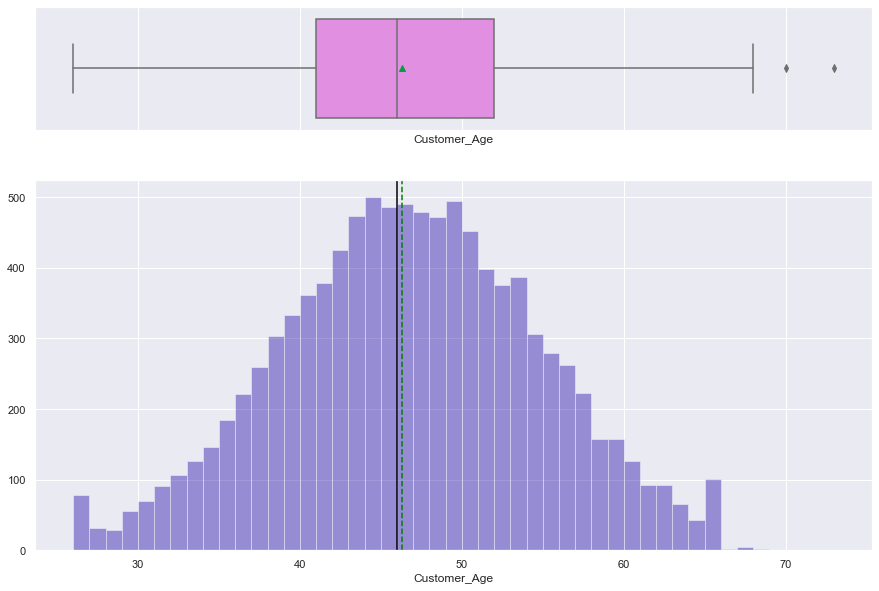

In [390]:
histogram_boxplot(data['Customer_Age'])

Gender


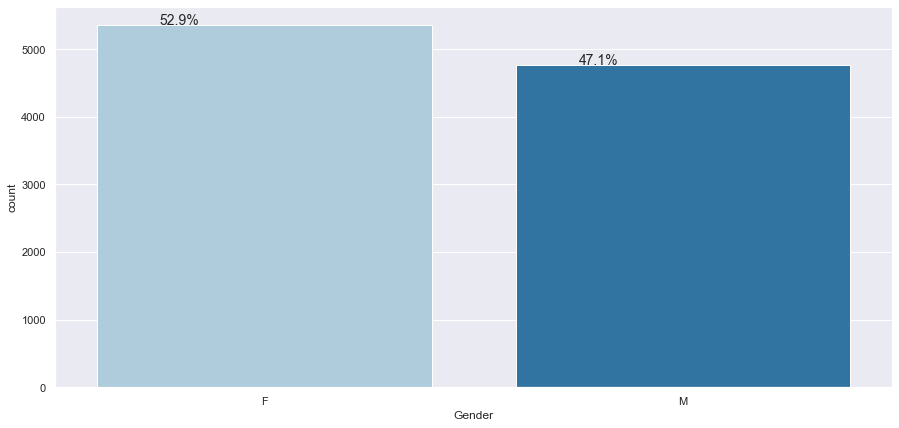

Dependent_count


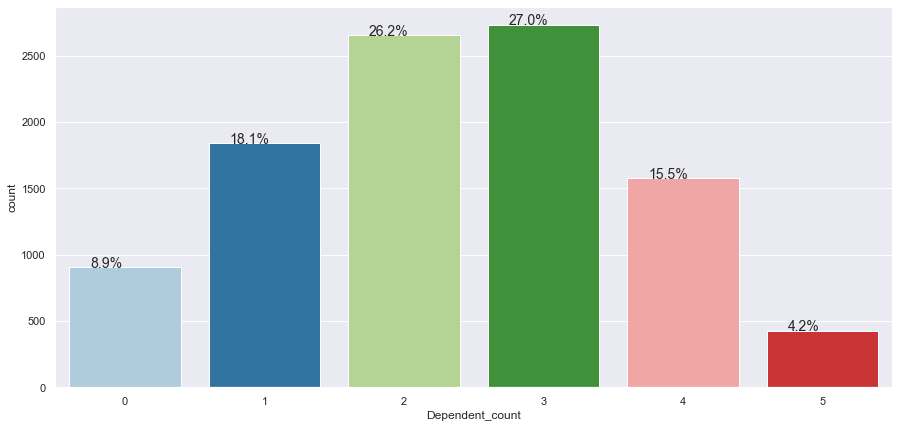

Education_Level


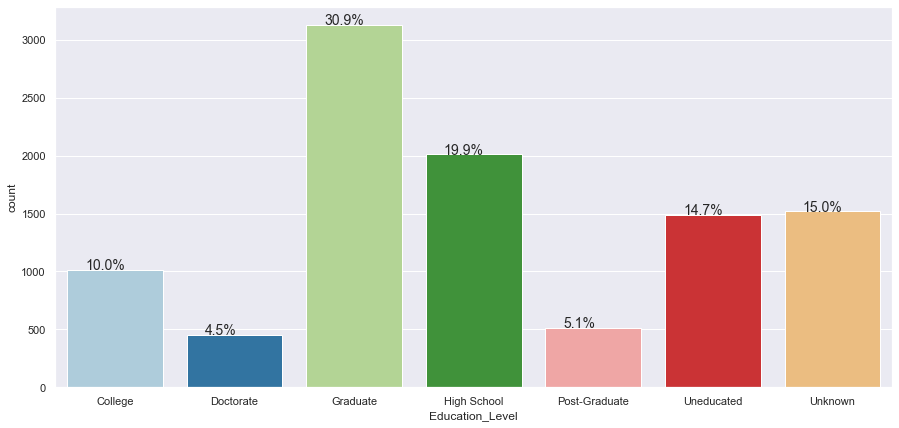

Marital_Status


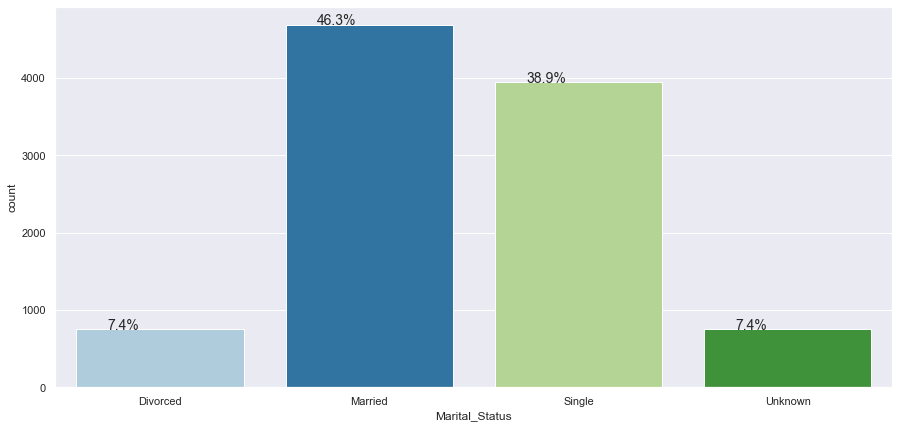

Income_Category


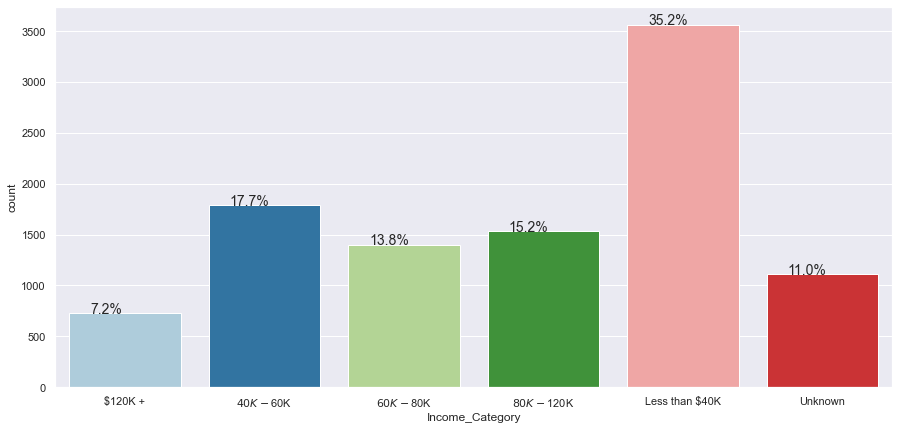

In [391]:
for i in ['Gender','Dependent_count','Education_Level','Marital_Status','Income_Category']:
        print(i)
        perc_on_bar(data[i])
        plt.show()

#### Customer Profile: Credit Card Usage 

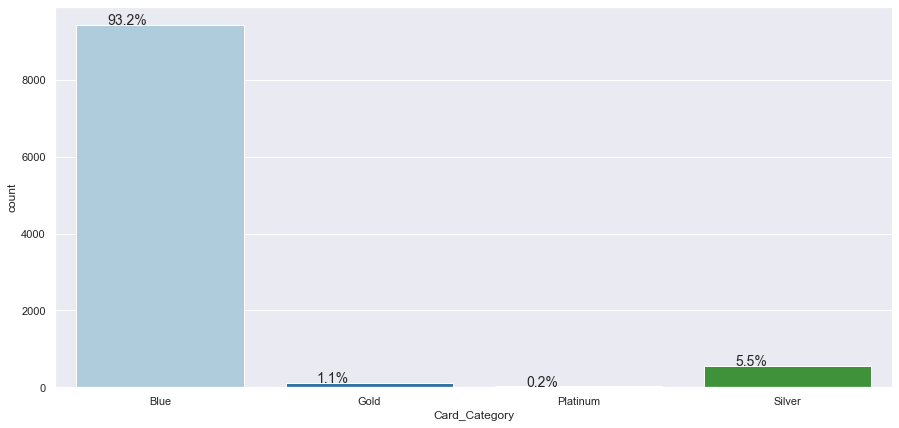

In [392]:
perc_on_bar(data['Card_Category'])

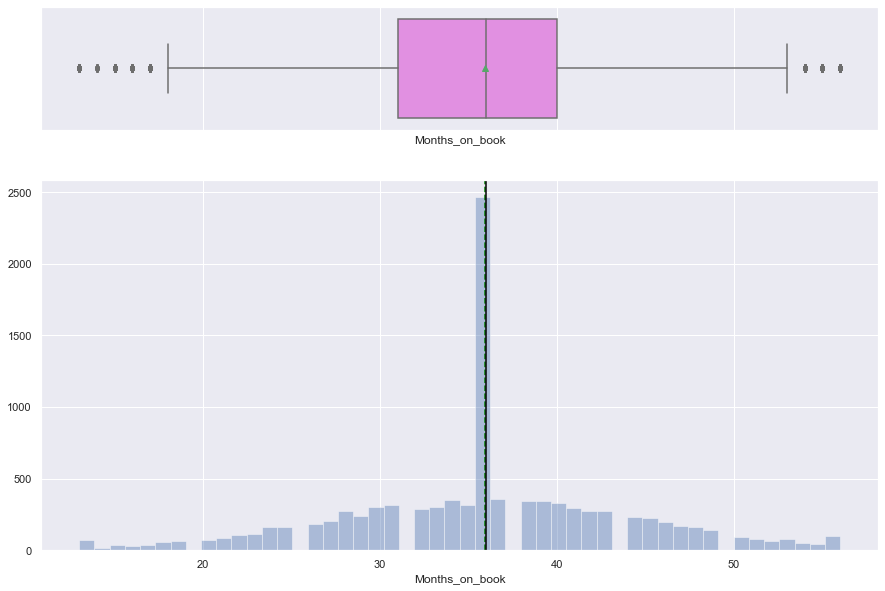

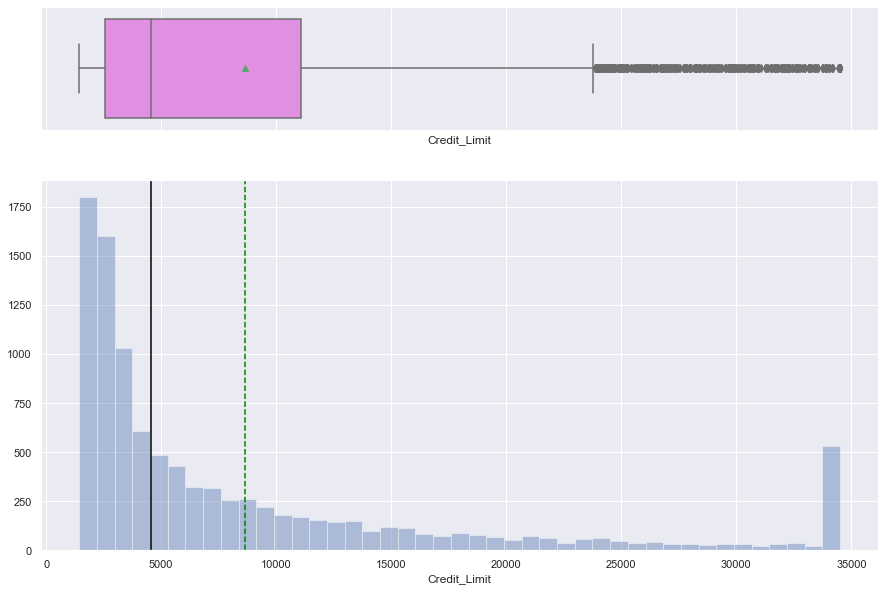

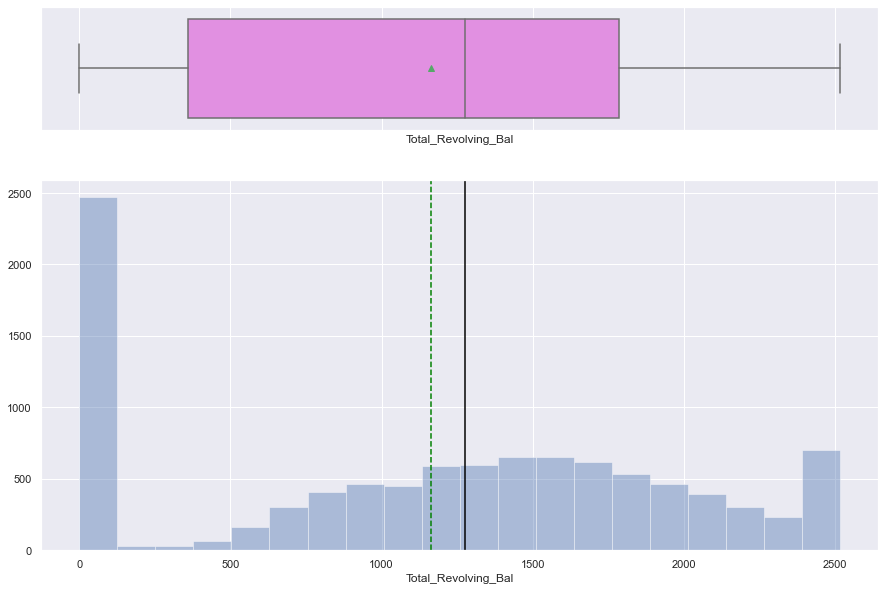

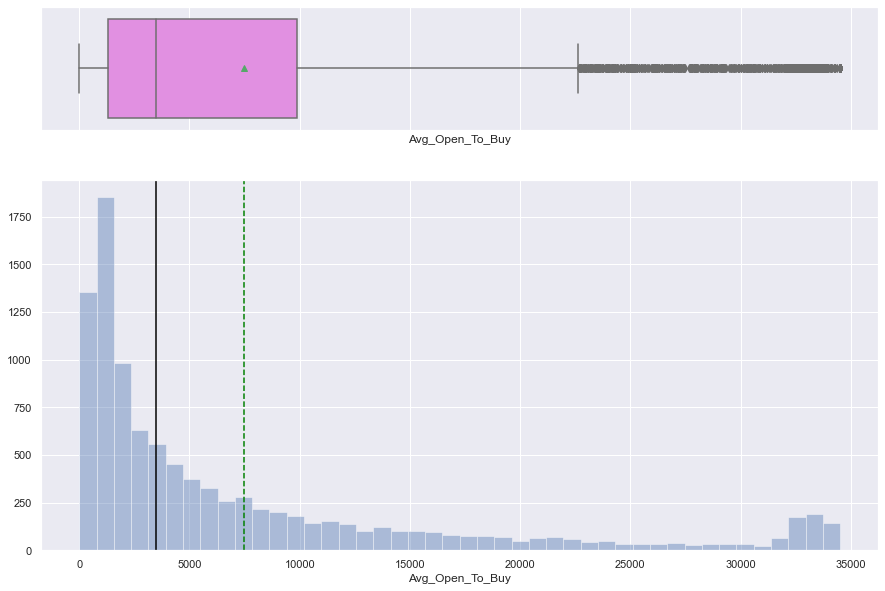

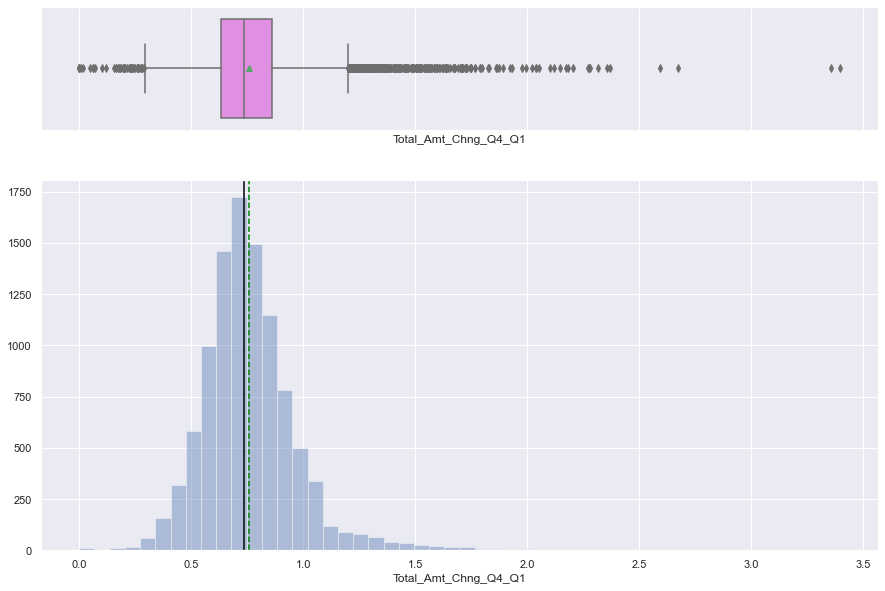

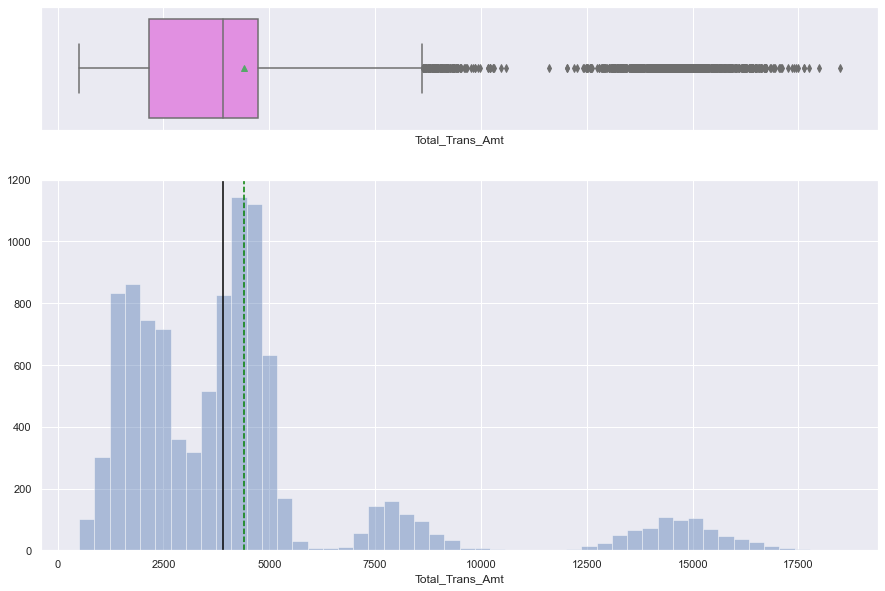

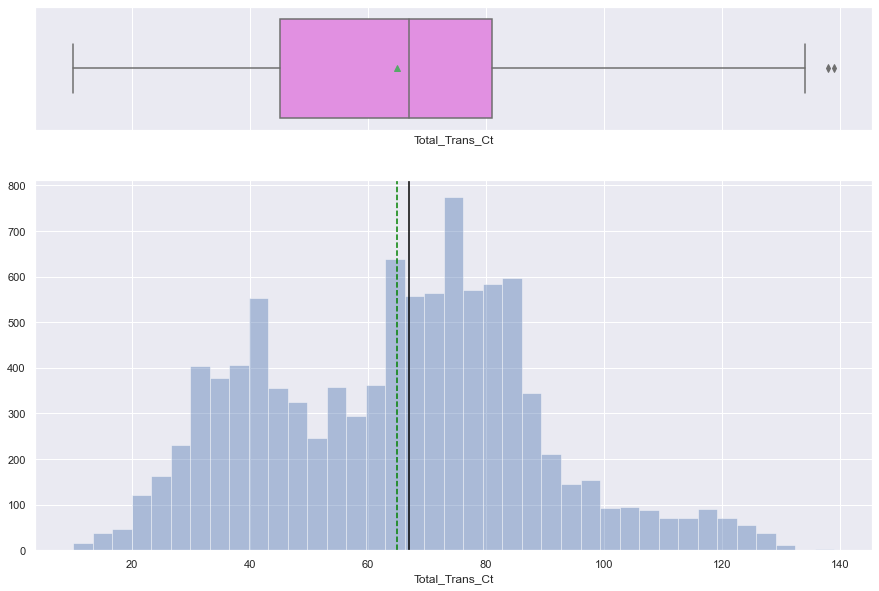

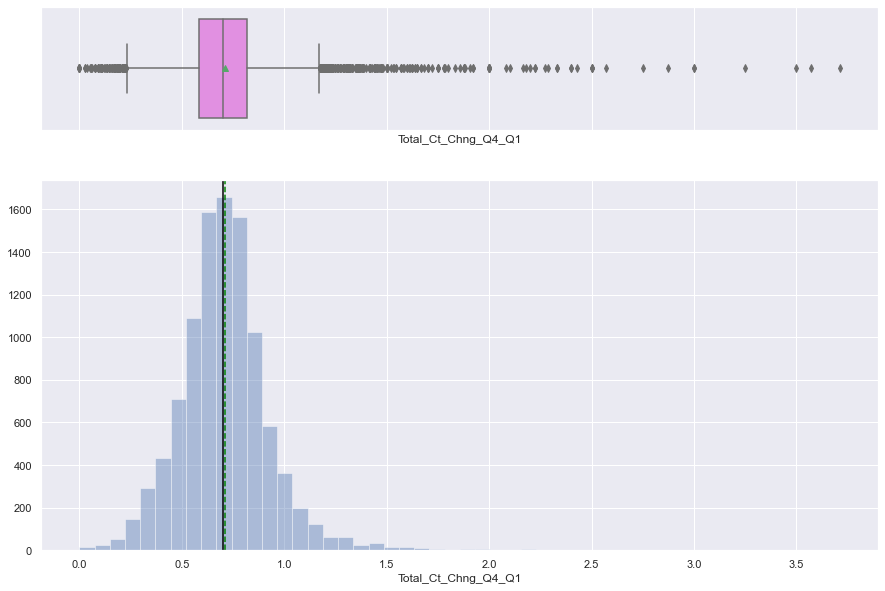

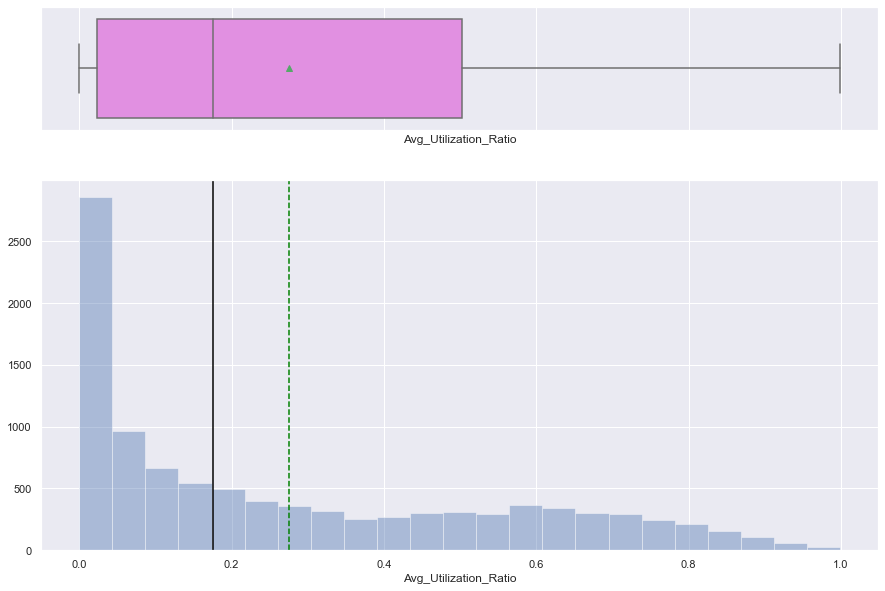

In [393]:
for i in ['Months_on_book','Credit_Limit', 'Total_Revolving_Bal','Avg_Open_To_Buy','Total_Amt_Chng_Q4_Q1',
          'Total_Trans_Amt','Total_Trans_Ct','Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio']:
    histogram_boxplot(data[i])
    plt.show()

### Note:

Total transaction amount and total transaction count appear to be multimodal. This potentially means that there are several groups of customers.

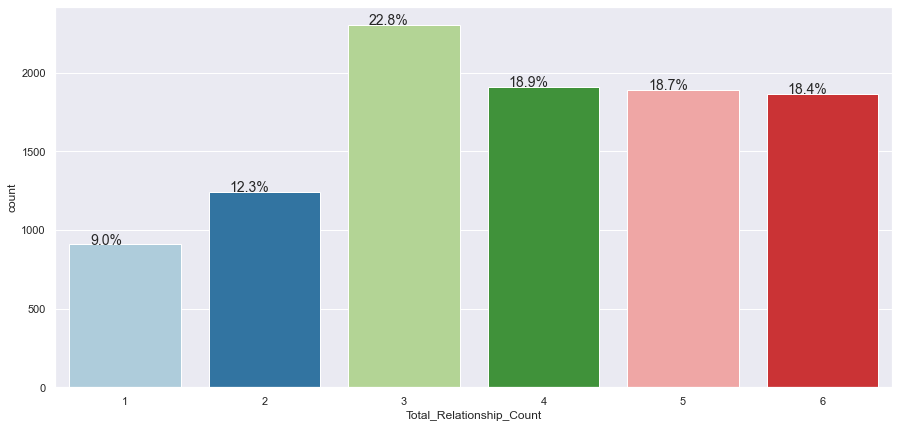

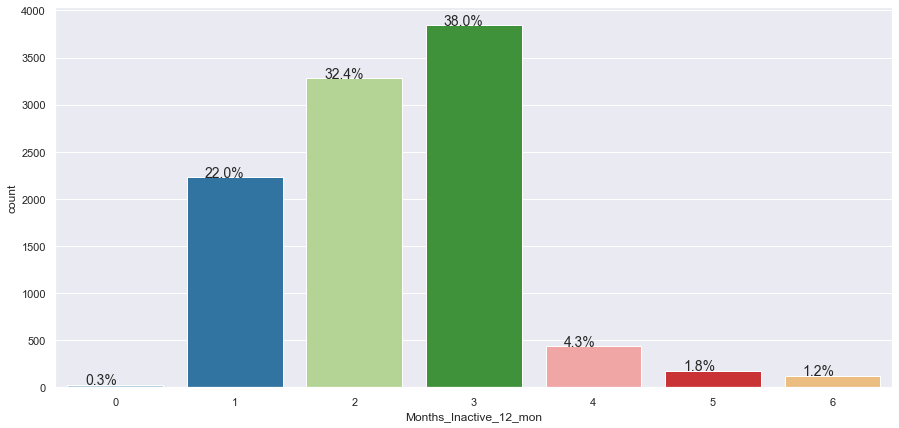

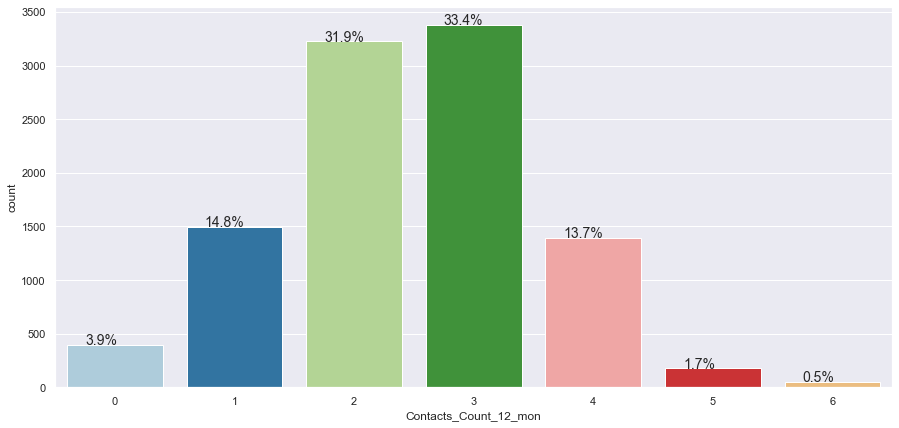

In [394]:
for i in ['Total_Relationship_Count','Months_Inactive_12_mon','Contacts_Count_12_mon']:
    perc_on_bar(data[i])
    plt.show()

### Bivariate Analysis

#### Customer profile: Demographics vs. Target variable ('Attrition_Flag')

Gender
Attrition_Flag  Attrited Customer  Existing Customer    All
Gender                                                     
F                             930               4428   5358
M                             697               4072   4769
All                          1627               8500  10127
------------------------------------------------------------------------------------------------------------------------


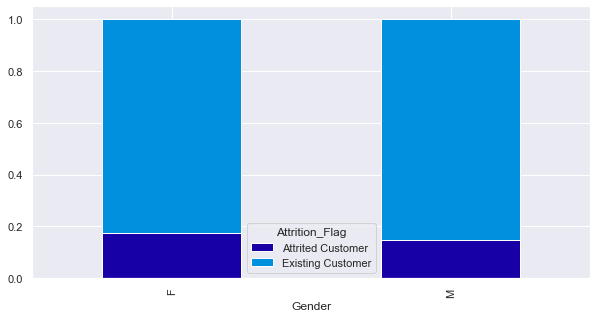

Dependent_count
Attrition_Flag   Attrited Customer  Existing Customer    All
Dependent_count                                             
0                              135                769    904
1                              269               1569   1838
2                              417               2238   2655
3                              482               2250   2732
4                              260               1314   1574
5                               64                360    424
All                           1627               8500  10127
------------------------------------------------------------------------------------------------------------------------


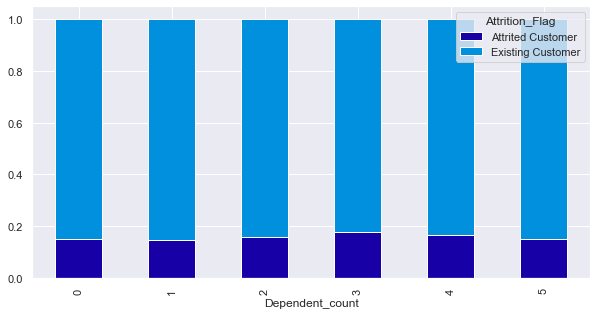

Education_Level
Attrition_Flag   Attrited Customer  Existing Customer    All
Education_Level                                             
College                        154                859   1013
Doctorate                       95                356    451
Graduate                       487               2641   3128
High School                    306               1707   2013
Post-Graduate                   92                424    516
Uneducated                     237               1250   1487
Unknown                        256               1263   1519
All                           1627               8500  10127
------------------------------------------------------------------------------------------------------------------------


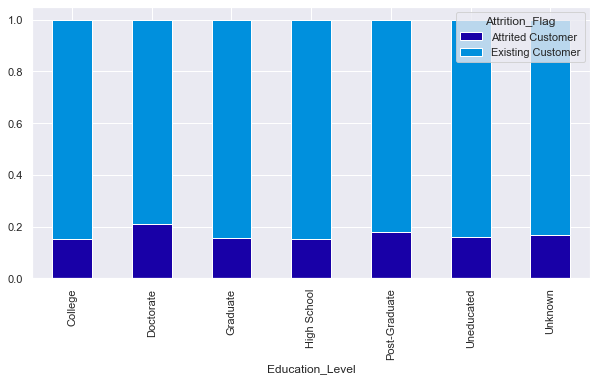

Marital_Status
Attrition_Flag  Attrited Customer  Existing Customer    All
Marital_Status                                             
Divorced                      121                627    748
Married                       709               3978   4687
Single                        668               3275   3943
Unknown                       129                620    749
All                          1627               8500  10127
------------------------------------------------------------------------------------------------------------------------


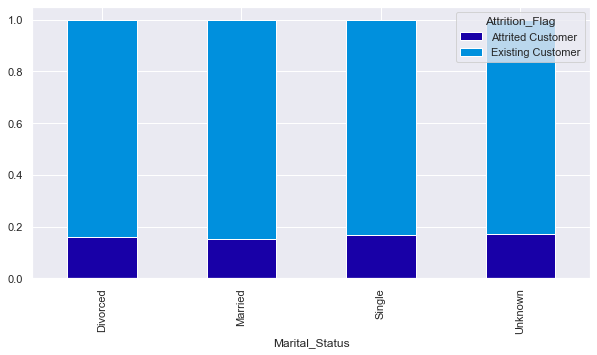

Income_Category
Attrition_Flag   Attrited Customer  Existing Customer    All
Income_Category                                             
$120K +                        126                601    727
$40K - $60K                    271               1519   1790
$60K - $80K                    189               1213   1402
$80K - $120K                   242               1293   1535
Less than $40K                 612               2949   3561
Unknown                        187                925   1112
All                           1627               8500  10127
------------------------------------------------------------------------------------------------------------------------


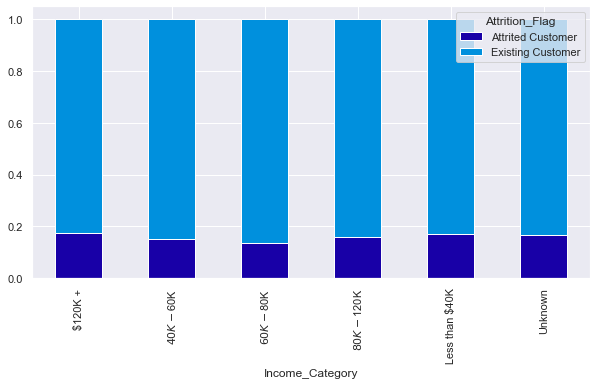

In [395]:
for i in ['Gender','Dependent_count','Education_Level','Marital_Status','Income_Category']:
        print(i)
        stacked_plot(data[i])
        plt.show()

#### Customer profile: Credit Card Usage vs. Target variable ('Attrition_Flag')

Attrition_Flag  Attrited Customer  Existing Customer    All
Card_Category                                              
Blue                         1519               7917   9436
Gold                           21                 95    116
Platinum                        5                 15     20
Silver                         82                473    555
All                          1627               8500  10127
------------------------------------------------------------------------------------------------------------------------


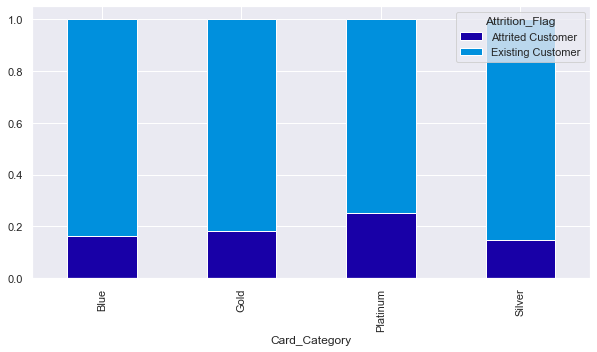

In [396]:
stacked_plot(data['Card_Category'])

Attrition_Flag            Attrited Customer  Existing Customer    All
Total_Relationship_Count                                             
1                                       233                677    910
2                                       346                897   1243
3                                       400               1905   2305
4                                       225               1687   1912
5                                       227               1664   1891
6                                       196               1670   1866
All                                    1627               8500  10127
------------------------------------------------------------------------------------------------------------------------


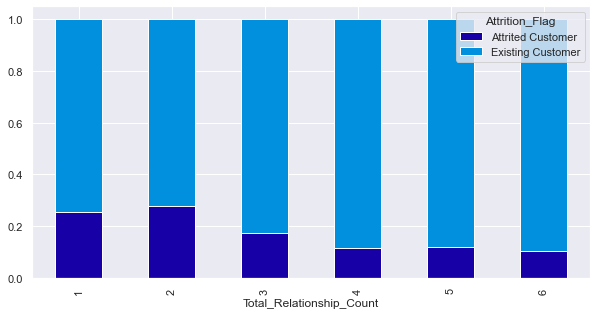

Attrition_Flag          Attrited Customer  Existing Customer    All
Months_Inactive_12_mon                                             
0                                      15                 14     29
1                                     100               2133   2233
2                                     505               2777   3282
3                                     826               3020   3846
4                                     130                305    435
5                                      32                146    178
6                                      19                105    124
All                                  1627               8500  10127
------------------------------------------------------------------------------------------------------------------------


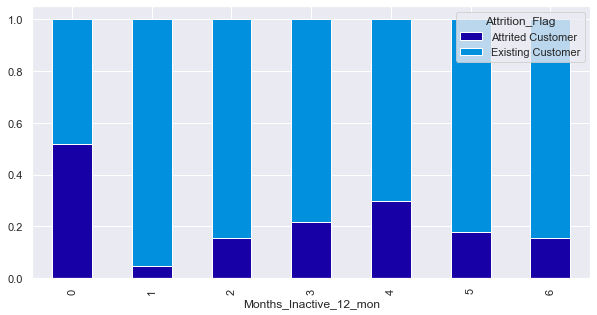

Attrition_Flag         Attrited Customer  Existing Customer    All
Contacts_Count_12_mon                                             
0                                      7                392    399
1                                    108               1391   1499
2                                    403               2824   3227
3                                    681               2699   3380
4                                    315               1077   1392
5                                     59                117    176
6                                     54                  0     54
All                                 1627               8500  10127
------------------------------------------------------------------------------------------------------------------------


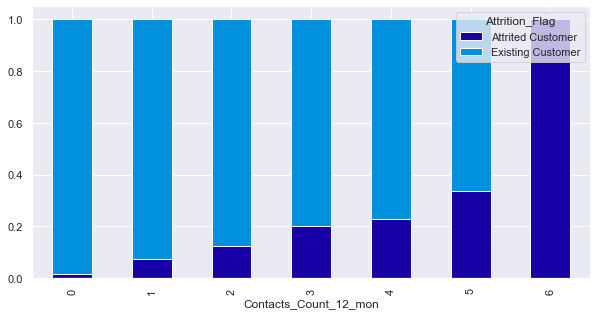

In [397]:
for i in ['Total_Relationship_Count','Months_Inactive_12_mon','Contacts_Count_12_mon']:
    stacked_plot(data[i])
    plt.show()

In [398]:
data.groupby(['Attrition_Flag']).mean()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
Attrition_Flag,,,,,,,,,,,,,,
Attrited Customer,46.659496,2.402581,36.178242,3.279656,2.693301,2.972342,8136.039459,672.822987,7463.216472,0.694277,3095.025814,44.933620,0.554386,0.162475
Existing Customer,46.262118,2.335412,35.880588,3.914588,2.273765,2.356353,8726.877518,1256.604118,7470.273400,0.772510,4654.655882,68.672588,0.742434,0.296412


In [399]:
prop_Y = data['Attrition_Flag'].value_counts(normalize=True)
print(prop_Y)

Existing Customer    0.83934
Attrited Customer    0.16066
Name: Attrition_Flag, dtype: float64


In [400]:
#replacing values in 'Attrition_Flag' column with 1 for 'Attrited Customer' 
#and 0 for 'Existing Customer'for this analysis:
data['Attrition_Flag'].replace('Attrited Customer',1,inplace=True)
data['Attrition_Flag'].replace('Existing Customer',0,inplace=True)
data['Attrition_Flag'] = data['Attrition_Flag'].astype('int64')   

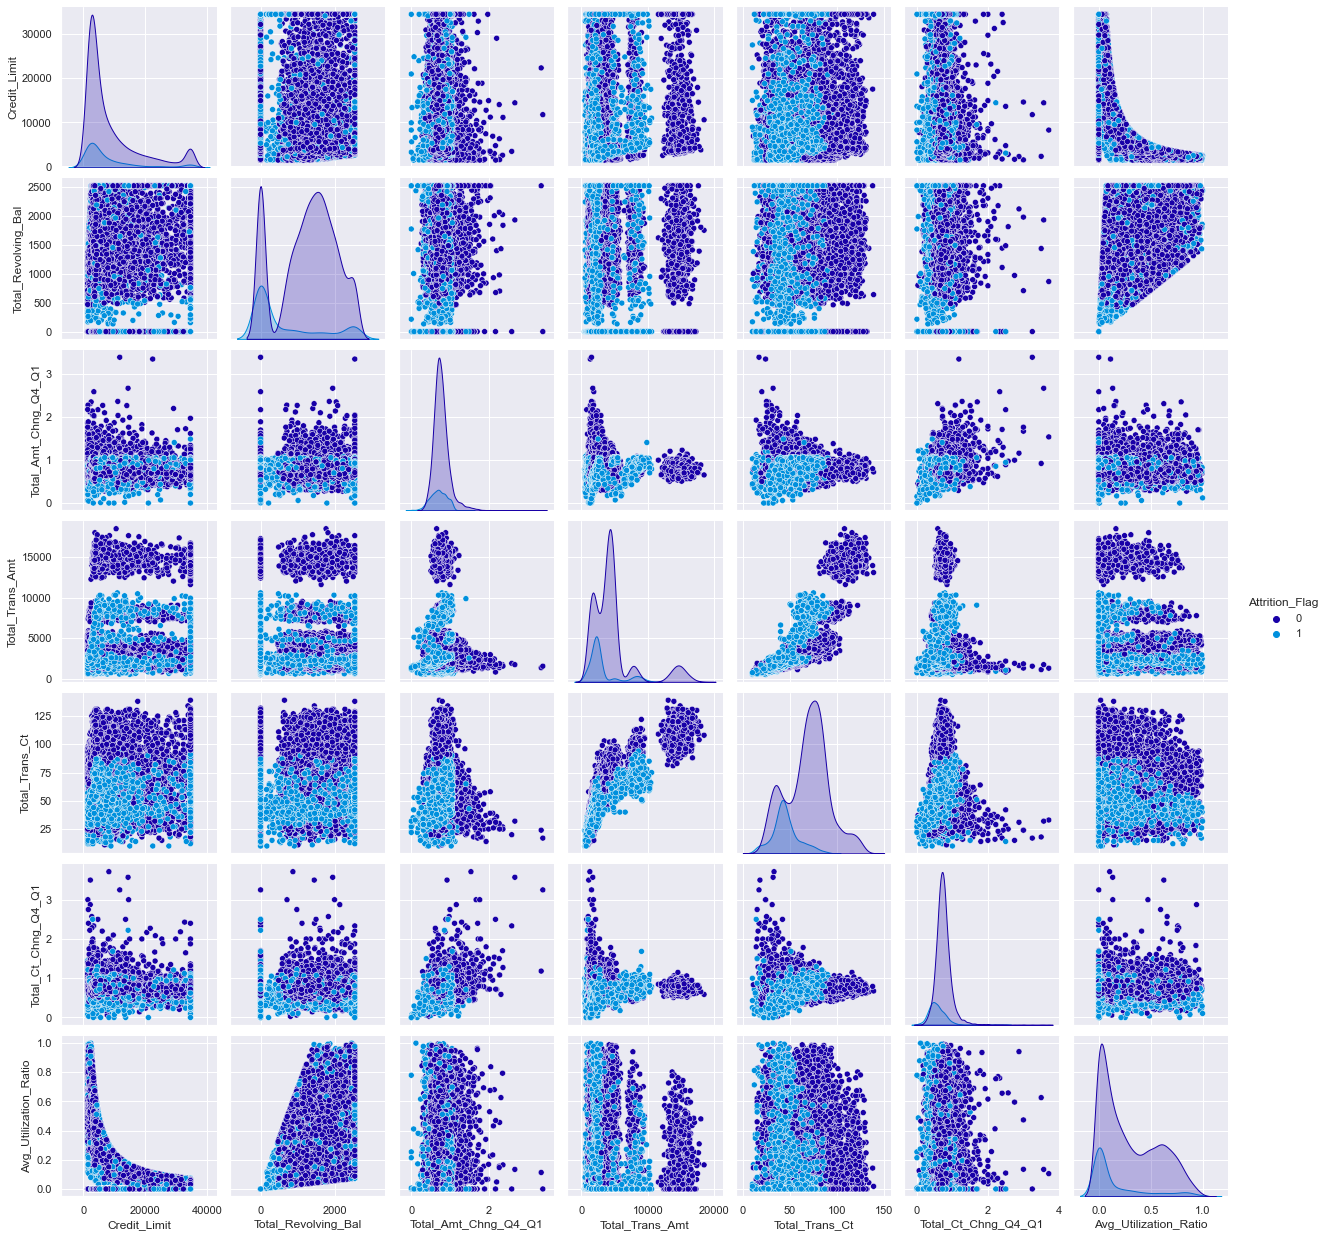

In [401]:
sns.pairplot(data[['Credit_Limit', 'Total_Revolving_Bal','Total_Amt_Chng_Q4_Q1',
          'Total_Trans_Amt','Total_Trans_Ct','Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio','Attrition_Flag' ]], hue='Attrition_Flag' , diag_kind = 'kde')
plt.show()

#### Note:
There appear to be interesting relationships between the credit limit, average open to buy, total revolving balance and total transactions amount and count vs attrition flag. Customers with fewer transactions, lower credit limit and total revolving balance tend to churn more. In other words, customers who use their credit cards less appear to be more likely to leave the bank in the future.

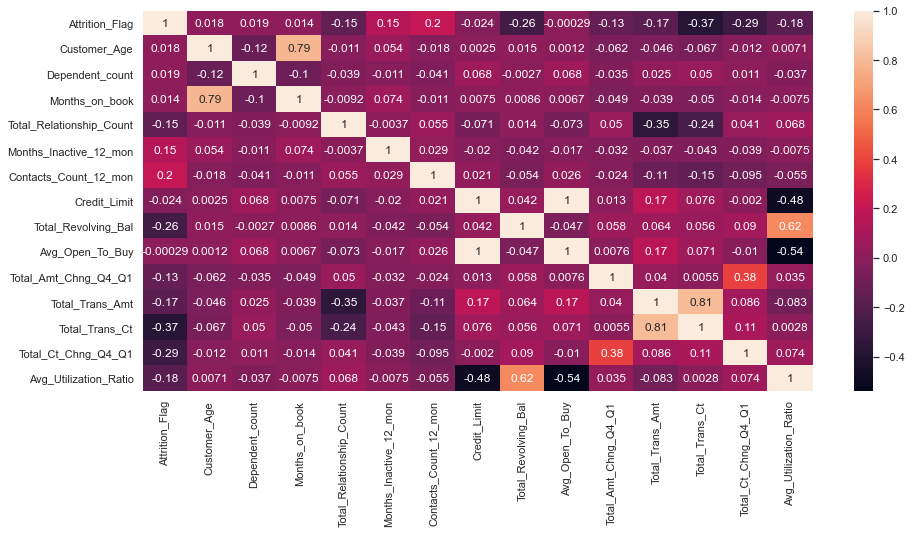

In [170]:
plt.figure(figsize=(15,7))
sns.heatmap(data.corr(),
            annot=True, 
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="YlGnBu",
            fmt='0.2f')
plt.show()

#### Note:
* Attrition flag has a positive correlation with Months_Inactive_12_mon, Contacts_Count_12_mon. 
* Attrition flag has a negative correlation with Total_Relationship_count, Total_Revolving_Balance, Total_Amt_Chng_Q4_Q1, Total_Trans_Amt, Total_Trans_Ct, Total_CT_Chng_Q4_Q1 and Avg_Utilization_Ratio

In [24]:
data.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,0,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,0,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,0,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,0,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [25]:
def plot(x,target='Attrition_Flag'):
    fig,axs = plt.subplots(2,2,figsize=(12,10))
    axs[0, 0].set_title('Distribution Current Customers')
    sns.distplot(data[(data[target] == 0 )][x],ax=axs[0,0],color='teal')
    axs[0, 1].set_title('Distribution Churned Customers')
    sns.distplot(data[(data[target] == 1)][x],ax=axs[0,1],color='orange')
    axs[1,0].set_title('Boxplot w.r.t target')
    sns.boxplot(data[target],data[x],ax=axs[1,0],palette='gist_rainbow')
    axs[1,1].set_title('Boxplot w.r.t target - Without outliers')
    sns.boxplot(data[target],data[x],ax=axs[1,1],showfliers=False,palette='gist_rainbow')
    plt.tight_layout()
    plt.show()

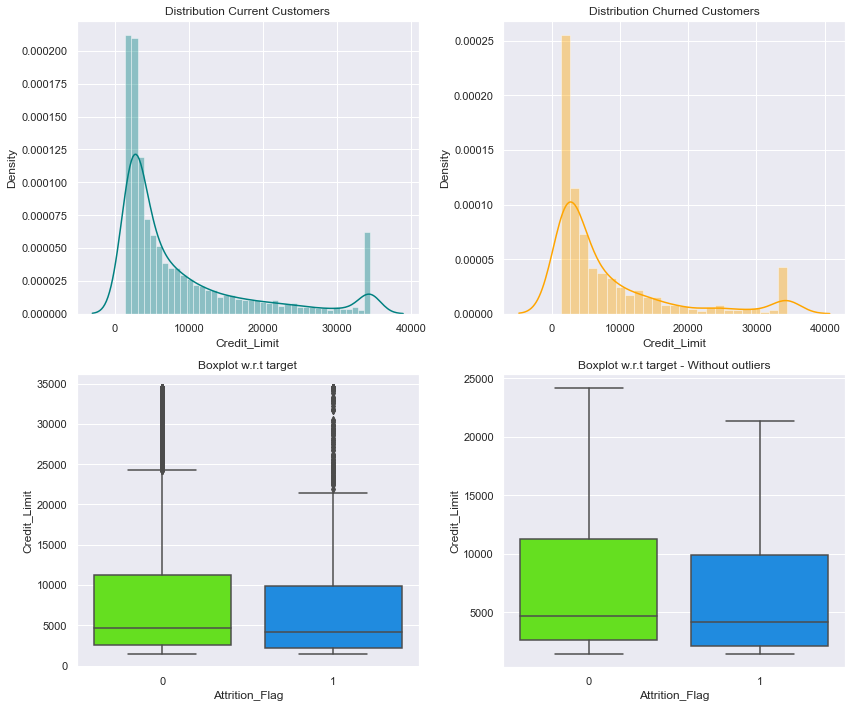

In [26]:
plot('Credit_Limit')

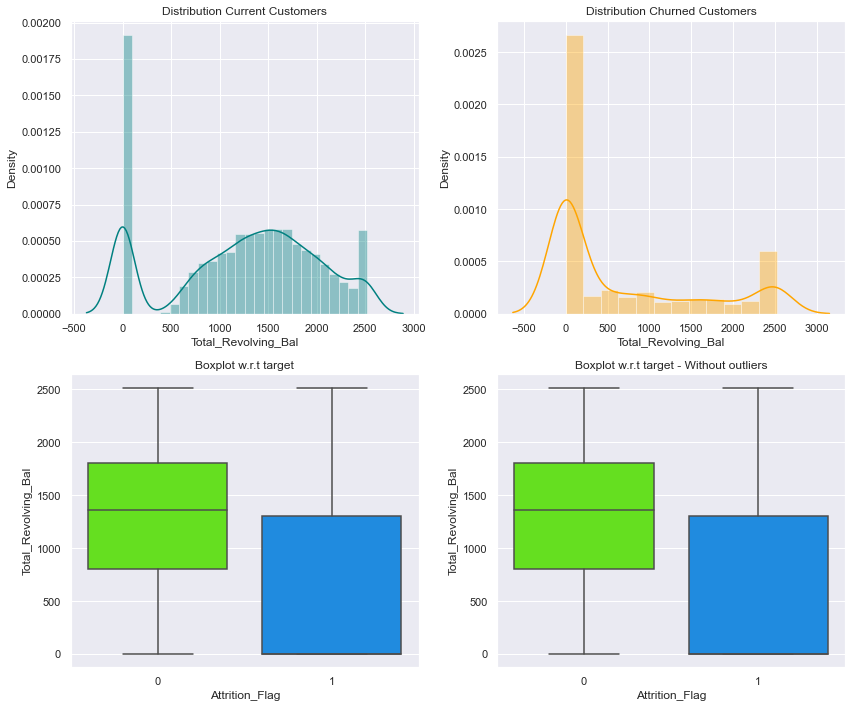

In [77]:
plot('Total_Revolving_Bal')

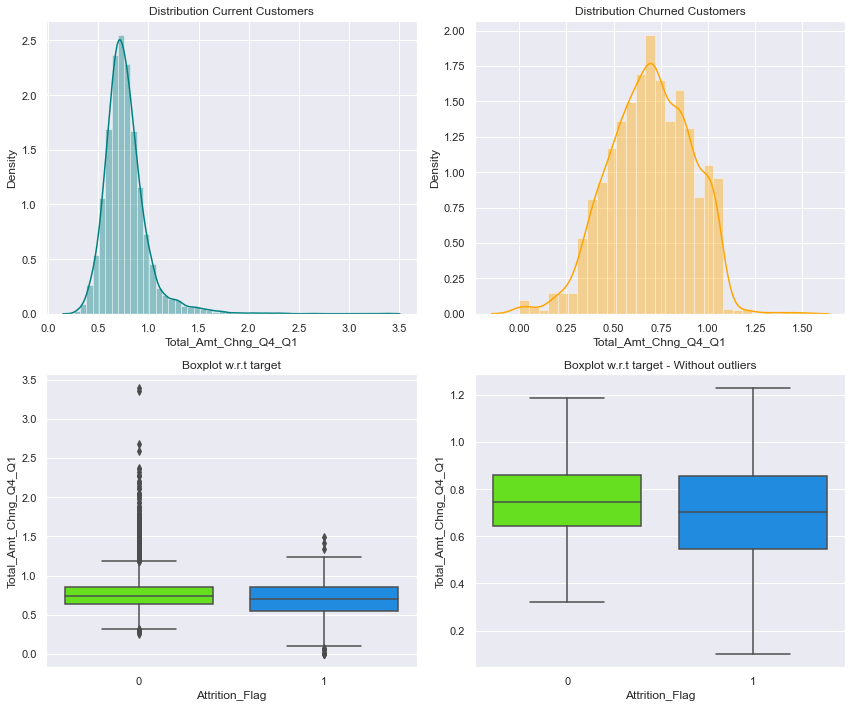

In [78]:
plot('Total_Amt_Chng_Q4_Q1')

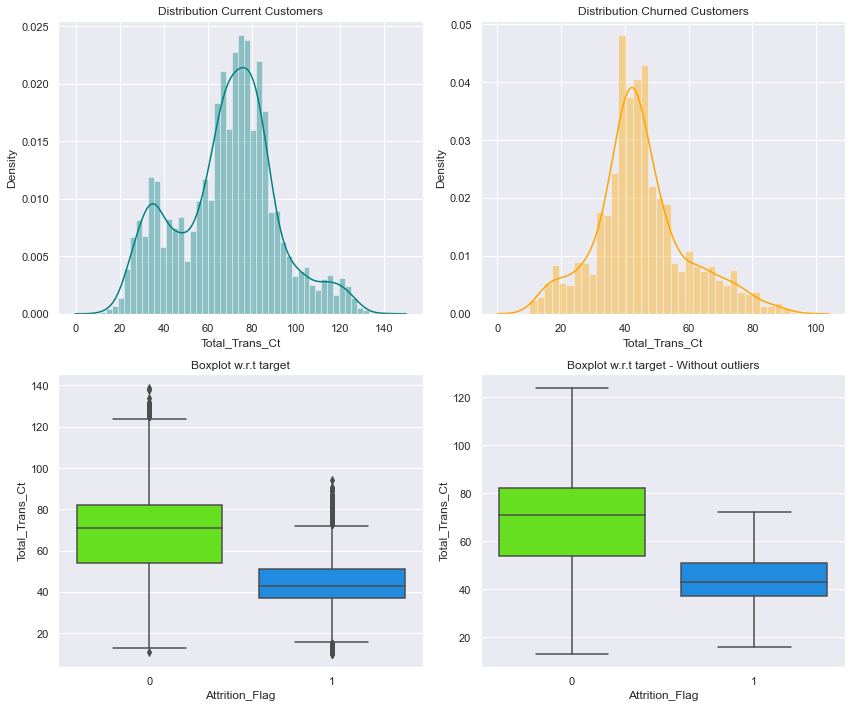

In [79]:
plot('Total_Trans_Ct')

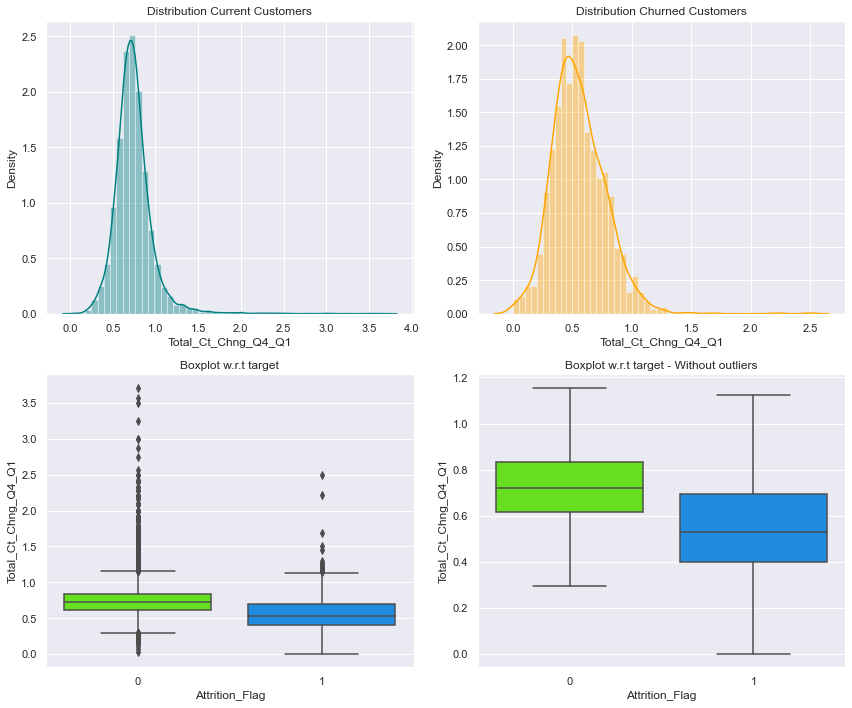

In [80]:
plot( 'Total_Ct_Chng_Q4_Q1')

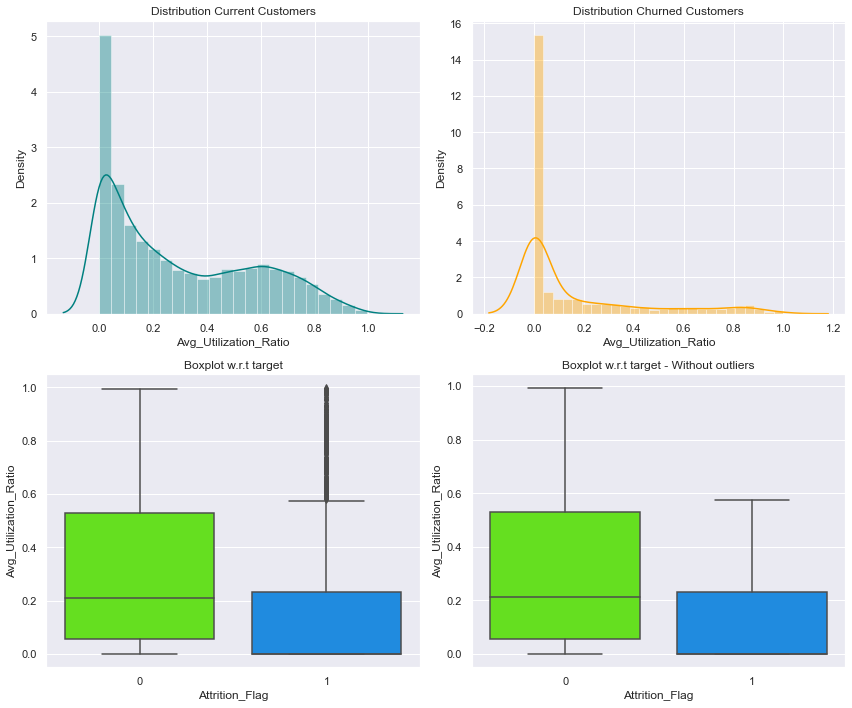

In [81]:
plot('Avg_Utilization_Ratio')

#### Note: 
There are quite a few outliers present in data. However, for the purpose of the analysis they are not going to be treated as we will try to learn from them.

## <a id = "link2"></a> Insights Based on Exploratory Data Analysis (EDA)


The original dataset contains 10,127 rows and 22 columns. There are no missing values, except for the last column that contains all missing values which was removed as well as 'CLIENTNUM' column. Additionally, object type columns were turned into categories to reduce memory usage. 'Attrition_flag' is the dependent variable of category type.

Based on EDA, consumer demografic data, such as gender, dependent count, education level, marital status or income category appear to have little to no impact on whether the customer will churn or not.

However, customer behavior appears to be a more solid predictor of attrition. For instance, all customers  who contacted the bank 6 times in the last 12 months churned. This suggests that Thera Bank should consider examining and improving its customer service. 

Also, customers who use their credit cards more often and use multiple products of the bank tend to be more likely to stay:

* customers that are more likely to stay have higher on average: number of relationships with the bank, credit limit, total revolving balance, total transaction amount and count, and average utilization ratio.

The following variables are highly correlated:
* Months_on_book and Customer_Age (0.79)
* Credit_Limit and Avg_Open_To_Buy (1)
* Total_Trans_Amt and Total_Trans_Ct (0.81)
* Avg_Utilization_Ratio and Total_Revolving_Bal(0.62)

Using correlations of 0.8 and above ( or -0.8 and below) as a guideline  to remove highly correlated variables, the following columns are going to be removed from the original dataset:
* Avg_Open_To_Buy
* Total_Trans_Amt

## <a id = "link3"></a> Data Pre-Processing

In [27]:
data.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,0,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,0,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,0,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,0,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [28]:
#Dropping columns 'Avg_Open_To_Buy' and 'Total_Trans_Amt' due to high correlation with 'Credit_Limit' and '
#Total_Trans_CT' respectively
data = data.drop(['Avg_Open_To_Buy', 'Total_Trans_Amt'], axis = 1)

In [29]:
#replace "Post-Graduate" with "Graduate" since Post graduate includes graduate work
data["Education_Level"] = data["Education_Level"].replace("Post-Graduate", "Graduate")

In [30]:
data.isnull().sum()

Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [31]:
cols = data.select_dtypes(include=['object','category'])
for i in cols.columns:
    print(data[i].value_counts())
    print('*'*30)

F    5358
M    4769
Name: Gender, dtype: int64
******************************
Graduate       3644
High School    2013
Unknown        1519
Uneducated     1487
College        1013
Doctorate       451
Name: Education_Level, dtype: int64
******************************
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: Marital_Status, dtype: int64
******************************
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: Income_Category, dtype: int64
******************************
Blue        9436
Silver       555
Gold         116
Platinum      20
Name: Card_Category, dtype: int64
******************************


#### Note:
Even though it appears that data has no missing values, there are quite a few categories that are 'Unknown' notably contained in columns Education_Level, Marital_Status and Income_Category. Assuming that this data is missing, I am going to replace 'Unknown' entries with null values and treat them as such.

In [32]:
data = data.replace('Unknown', np.nan)

In [33]:
data.isnull().sum()

Attrition_Flag                 0
Customer_Age                   0
Gender                         0
Dependent_count                0
Education_Level             1519
Marital_Status               749
Income_Category             1112
Card_Category                  0
Months_on_book                 0
Total_Relationship_Count       0
Months_Inactive_12_mon         0
Contacts_Count_12_mon          0
Credit_Limit                   0
Total_Revolving_Bal            0
Total_Amt_Chng_Q4_Q1           0
Total_Trans_Ct                 0
Total_Ct_Chng_Q4_Q1            0
Avg_Utilization_Ratio          0
dtype: int64

In [34]:
Gender =  {"F":0,"M":1}
data['Gender']=data['Gender'].map(Gender)

Education_Level = {"Uneducated": 0, "High School":1, "College":2, "Graduate":3, "Doctorate":4}
data['Education_Level']=data['Education_Level'].map(Education_Level)

Marital_Status =  {"Married":0,"Single":1, "Divorced":2}
data['Marital_Status']=data['Marital_Status'].map(Marital_Status)

Income_Category =  {"Less than $40K":0,"$40K - $60K":1, "$60K - $80K":2, "$80K - $120K":3, "$120K +":4}
data['Income_Category']=data['Income_Category'].map(Income_Category)

Card_Category =  {"Blue":0,"Silver":1, "Gold":2, "Platinum":3}
data['Card_Category']=data['Card_Category'].map(Card_Category)

In [38]:
data = data.rename(columns={"Attrition_Flag": "Attrited_Customer"}, errors="raise")

In [40]:
data['Attrited_Customer'].replace(1,'yes',inplace=True)
data['Attrited_Customer'].replace(0,'no',inplace=True)

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Attrited_Customer         10127 non-null  object  
 1   Customer_Age              10127 non-null  int64   
 2   Gender                    10127 non-null  category
 3   Dependent_count           10127 non-null  int64   
 4   Education_Level           8608 non-null   category
 5   Marital_Status            9378 non-null   category
 6   Income_Category           9015 non-null   category
 7   Card_Category             10127 non-null  category
 8   Months_on_book            10127 non-null  int64   
 9   Total_Relationship_Count  10127 non-null  int64   
 10  Months_Inactive_12_mon    10127 non-null  int64   
 11  Contacts_Count_12_mon     10127 non-null  int64   
 12  Credit_Limit              10127 non-null  float64 
 13  Total_Revolving_Bal       10127 non-null  int6

In [42]:
prop_Y = data['Attrited_Customer'].value_counts(normalize=True)
print(prop_Y)

no     0.83934
yes    0.16066
Name: Attrited_Customer, dtype: float64


In [43]:
data.head()

,Attrited_Customer,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,no,45,1,3,1,0,2,0,39,5,1,3,12691.0,777,1.335,42,1.625,0.061
1,no,49,0,5,3,1,0,0,44,6,1,2,8256.0,864,1.541,33,3.714,0.105
2,no,51,1,3,3,0,3,0,36,4,1,0,3418.0,0,2.594,20,2.333,0.000
3,no,40,0,4,1,NaN,0,0,34,3,4,1,3313.0,2517,1.405,20,2.333,0.760
4,no,40,1,3,0,0,2,0,21,5,1,0,4716.0,0,2.175,28,2.500,0.000


* Split Data

In [44]:
X = data.drop(['Attrited_Customer'],axis=1)
Y = data['Attrited_Customer'].apply(lambda x : 1 if x=='yes' else 0)

In [45]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.30, random_state=1, stratify=Y
)
print(X_train.shape, X_test.shape)

(7088, 17) (3039, 17)


* Missing Value Treatment:

In [47]:
imputer = KNNImputer(n_neighbors=5)

In [48]:
#Fit and transform the train data
X_train=pd.DataFrame(imputer.fit_transform(X_train),columns=X_train.columns)

#Transform the test data 
X_test=pd.DataFrame(imputer.transform(X_test),columns=X_test.columns)

In [49]:
print(X_train.isna().sum())
print('-'*30)
print(X_test.isna().sum())

Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64
------------------------------
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Ct            

In [50]:
def inverse_mapping(x,y):
    inv_dict = {v: k for k, v in x.items()}
    X_train[y] = np.round(X_train[y]).map(inv_dict).astype('category')
    X_test[y] = np.round(X_test[y]).map(inv_dict).astype('category')

In [51]:
inverse_mapping(Gender,'Gender')
inverse_mapping(Education_Level,'Education_Level')
inverse_mapping(Marital_Status,'Marital_Status')
inverse_mapping(Income_Category,'Income_Category')
inverse_mapping(Card_Category,'Card_Category')

In [52]:
cols = X_train.select_dtypes(include=['object','category'])
for i in cols.columns:
    print(X_train[i].value_counts())
    print('*'*30)

F    3770
M    3318
Name: Gender, dtype: int64
******************************
Graduate       2718
High School    1655
College        1367
Uneducated     1035
Doctorate       313
Name: Education_Level, dtype: int64
******************************
Married     3516
Single      3069
Divorced     503
Name: Marital_Status, dtype: int64
******************************
Less than $40K    2625
$40K - $60K       1553
$80K - $120K      1196
$60K - $80K       1193
$120K +            521
Name: Income_Category, dtype: int64
******************************
Blue        6621
Silver       375
Gold          78
Platinum      14
Name: Card_Category, dtype: int64
******************************


In [54]:
cols = X_test.select_dtypes(include=['object','category'])
for i in cols.columns:
    print(X_train[i].value_counts())
    print('*'*30)

F    3770
M    3318
Name: Gender, dtype: int64
******************************
Graduate       2718
High School    1655
College        1367
Uneducated     1035
Doctorate       313
Name: Education_Level, dtype: int64
******************************
Married     3516
Single      3069
Divorced     503
Name: Marital_Status, dtype: int64
******************************
Less than $40K    2625
$40K - $60K       1553
$80K - $120K      1196
$60K - $80K       1193
$120K +            521
Name: Income_Category, dtype: int64
******************************
Blue        6621
Silver       375
Gold          78
Platinum      14
Name: Card_Category, dtype: int64
******************************


* There are no missing values

In [55]:
X_train=pd.get_dummies(X_train,drop_first=True)
X_test=pd.get_dummies(X_test,drop_first=True)
print(X_train.shape, X_test.shape)

(7088, 26) (3039, 26)


In [56]:
X_train.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Ct,...,Education_Level_Uneducated,Marital_Status_Married,Marital_Status_Single,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,50.0,1.0,43.0,6.0,1.0,2.0,7985.0,0.0,1.032,72.0,...,0,1,0,1,0,0,0,0,0,0
1,50.0,0.0,36.0,3.0,3.0,2.0,5444.0,2499.0,0.468,80.0,...,0,0,0,0,1,0,0,0,0,0
2,26.0,0.0,13.0,6.0,3.0,4.0,1643.0,1101.0,0.713,50.0,...,0,0,1,1,0,0,0,0,0,0
3,65.0,0.0,55.0,3.0,3.0,0.0,2022.0,0.0,0.579,65.0,...,0,0,1,0,0,0,1,0,0,0
4,46.0,3.0,35.0,6.0,3.0,4.0,4930.0,0.0,1.019,77.0,...,0,0,1,0,0,1,0,0,0,0


## <a id = "link4"></a> Model Building - Logistic Regression

In [57]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model,train,test,train_y,test_y,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 
    
    pred_train = model.predict(train)
    pred_test = model.predict(test)
    
    train_acc = model.score(train,train_y)
    test_acc = model.score(test,test_y)
    
    train_recall = metrics.recall_score(train_y,pred_train)
    test_recall = metrics.recall_score(test_y,pred_test)
    
    train_precision = metrics.precision_score(train_y,pred_train)
    test_precision = metrics.precision_score(test_y,pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
        
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",model.score(train,train_y))
        print("Accuracy on test set : ",model.score(test,test_y))
        print("Recall on training set : ",metrics.recall_score(train_y,pred_train))
        print("Recall on test set : ",metrics.recall_score(test_y,pred_test))
        print("Precision on training set : ",metrics.precision_score(train_y,pred_train))
        print("Precision on test set : ",metrics.precision_score(test_y,pred_test))
    
    return score_list # returning the list with train and test scores

In [58]:
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [59]:
log_reg = LogisticRegression(random_state=1)
log_reg.fit(X_train,y_train)

LogisticRegression(random_state=1)

#### Logistic model performance evaluation using KFold and cross_val_score:

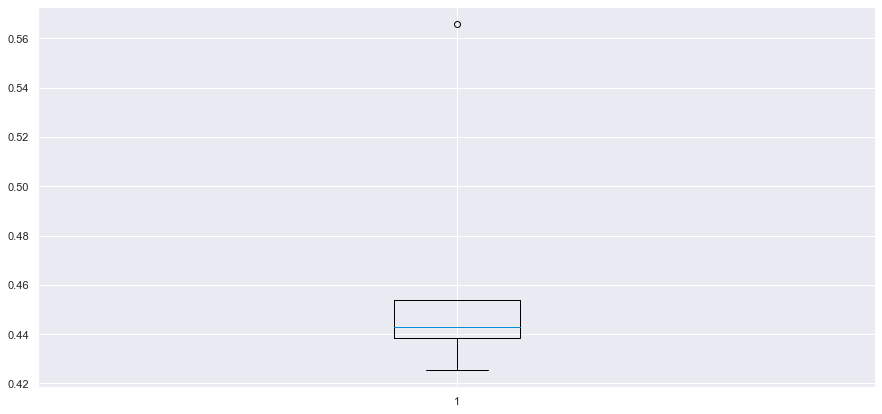

In [60]:
scoring='recall'
kfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=1)    
cv_result_bfr=cross_val_score(estimator=log_reg, X=X_train, y=y_train, scoring=scoring, cv=kfold)
plt.boxplot(cv_result_bfr)
plt.show()

* Performance on training set varies between 0.42 to 0.57 recall.

Accuracy on training set :  0.8882618510158014
Accuracy on test set :  0.8858177031918394
Recall on training set :  0.4618086040386304
Recall on test set :  0.4364754098360656
Precision on training set :  0.7460992907801418
Precision on test set :  0.7473684210526316


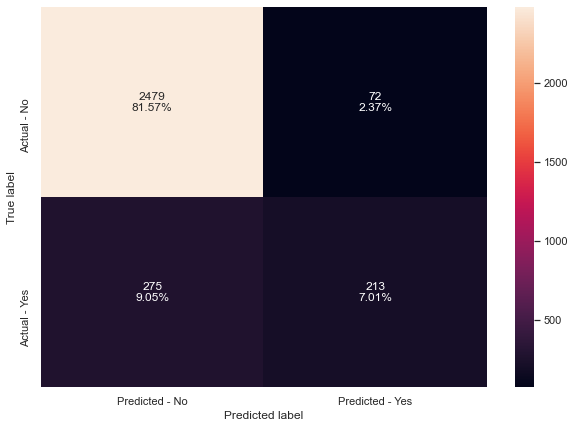

In [61]:
scores_LR = get_metrics_score(log_reg,X_train,X_test,y_train,y_test)
make_confusion_matrix(log_reg,y_test)

#### Note: 
Accuracy, Recall and Precision scores on training and test sets are relatively close together, which is good. However, Recall score is very low. This might be imroved by addressing imbalance in data by oversampling using SMOTE.

#### Upsampling with SMOTE:

In [173]:
print("Before UpSampling, counts of label 'Yes': {}".format(sum(y_train==1)))
print("Before UpSampling, counts of label 'No': {} \n".format(sum(y_train==0)))

sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=1)   
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After UpSampling, counts of label 'Yes': {}".format(sum(y_train_over==1)))
print("After UpSampling, counts of label 'No': {} \n".format(sum(y_train_over==0)))


print('After UpSampling, the shape of train_X: {}'.format(X_train_over.shape))
print('After UpSampling, the shape of train_y: {} \n'.format(y_train_over.shape))

Before UpSampling, counts of label 'Yes': 1139
Before UpSampling, counts of label 'No': 5949 

After UpSampling, counts of label 'Yes': 5949
After UpSampling, counts of label 'No': 5949 

After UpSampling, the shape of train_X: (11898, 26)
After UpSampling, the shape of train_y: (11898,) 



In [174]:
log_reg_over = LogisticRegression(random_state = 1)
log_reg_over.fit(X_train_over,y_train_over)

LogisticRegression(random_state=1)

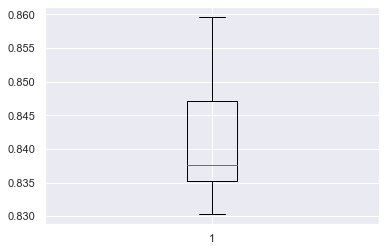

In [175]:
scoring='recall'
kfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=1)    
cv_result_over=cross_val_score(estimator=log_reg_over, X=X_train_over, y=y_train_over, scoring=scoring, cv=kfold)
plt.boxplot(cv_result_over)
plt.show()

#### Note: 
Performance on training set varies between 0.83 to 0.86 recall. This is an improvement as compared to the previous model.

Accuracy on training set :  0.8345940494200706
Accuracy on test set :  0.807502467917078
Recall on training set :  0.8404773911581779
Recall on test set :  0.7479508196721312
Precision on training set :  0.830702774547267
Precision on test set :  0.44135429262394194


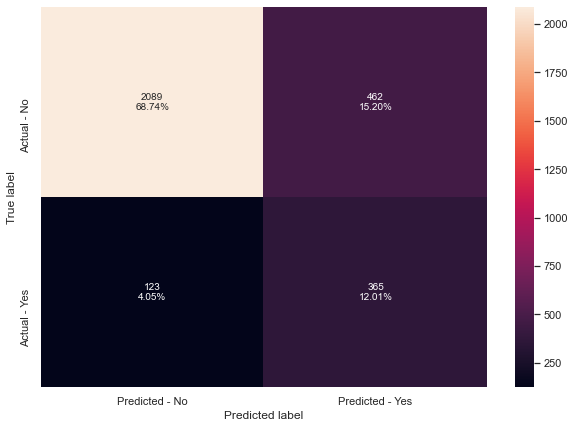

In [176]:
get_metrics_score(log_reg_over,X_train_over,X_test,y_train_over,y_test)
make_confusion_matrix(log_reg_over,y_test)

#### Note:
Recall numbers are higher on both training and test sets as compared to the previous model. However the model performs a little better on training (84%) than testing set (74%) which suggest that the model is overfit.

#### Regularization - Upsampling

In [177]:
# Choose the type of classifier. 
lr_estimator_over = LogisticRegression(random_state=1,solver='saga')

# Grid of parameters to choose from
parameters = {'C': np.arange(0.1,1.1,0.1)}

# Run the grid search
grid_obj = GridSearchCV(lr_estimator_over, parameters, scoring='recall')
grid_obj = grid_obj.fit(X_train_over, y_train_over)

# Set the clf to the best combination of parameters
lr_estimator_over = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
lr_estimator_over.fit(X_train_over, y_train_over)

LogisticRegression(C=0.1, random_state=1, solver='saga')

Accuracy on training set :  0.7208774583963692
Accuracy on test set :  0.7624218492925304
Recall on training set :  0.652210455538746
Recall on test set :  0.6311475409836066
Precision on training set :  0.7560405300077943
Precision on test set :  0.3623529411764706


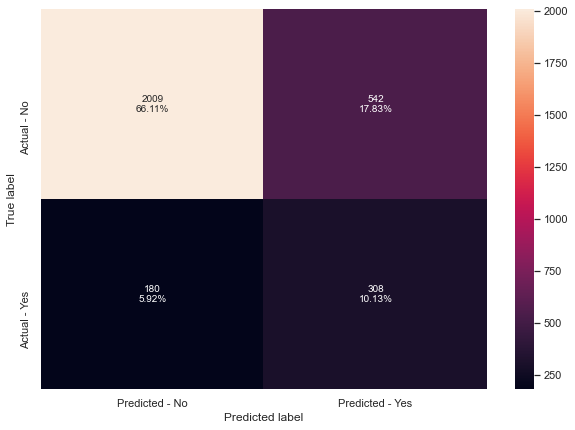

In [178]:
#Calculating different metrics
get_metrics_score(lr_estimator_over,X_train_over,X_test,y_train_over,y_test)

# creating confusion matrix
make_confusion_matrix(lr_estimator_over,y_test)

#### Downsampling with SMOTE

In [84]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state = 1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [85]:
print("Before Under Sampling, counts of label 'Yes': {}".format(sum(y_train==1)))
print("Before Under Sampling, counts of label 'No': {} \n".format(sum(y_train==0)))

print("After Under Sampling, counts of label 'Yes': {}".format(sum(y_train_un==1)))
print("After Under Sampling, counts of label 'No': {} \n".format(sum(y_train_un==0)))

print('After Under Sampling, the shape of train_X: {}'.format(X_train_un.shape))
print('After Under Sampling, the shape of train_y: {} \n'.format(y_train_un.shape))

Before Under Sampling, counts of label 'Yes': 1139
Before Under Sampling, counts of label 'No': 5949 

After Under Sampling, counts of label 'Yes': 1139
After Under Sampling, counts of label 'No': 1139 

After Under Sampling, the shape of train_X: (2278, 26)
After Under Sampling, the shape of train_y: (2278,) 



In [86]:
log_reg_under = LogisticRegression(random_state = 1)
log_reg_under.fit(X_train_un,y_train_un )

LogisticRegression(random_state=1)

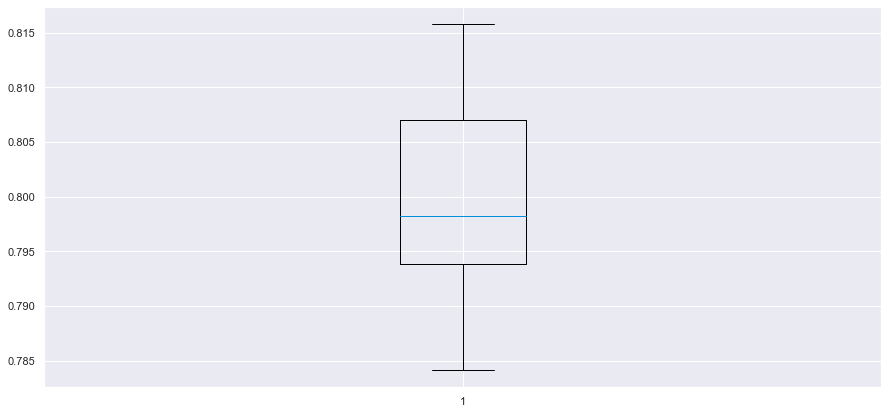

In [87]:
scoring='recall'
kfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=1)     
cv_result_under=cross_val_score(estimator=log_reg_under, X=X_train_un, y=y_train_un, scoring=scoring, cv=kfold)
plt.boxplot(cv_result_under)
plt.show()

Accuracy on training set :  0.8020193151887621
Accuracy on test set :  0.799276077657124
Recall on training set :  0.8033362598770851
Recall on test set :  0.7766393442622951
Precision on training set :  0.8012259194395797
Precision on test set :  0.43068181818181817


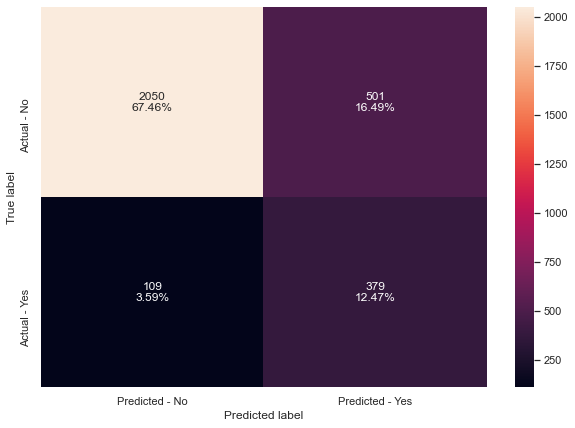

In [88]:
get_metrics_score(log_reg_under,X_train_un,X_test,y_train_un,y_test)
make_confusion_matrix(log_reg_under,y_test)

#### Regularization - Downsampling

In [166]:
lr_estimator_un = LogisticRegression(random_state=1,solver='saga')
parameters = {'C': np.arange(0.1,1.1,0.1)}
grid_obj = GridSearchCV(lr_estimator_un, parameters, scoring='recall')
grid_obj = grid_obj.fit(X_train_un, y_train_un)
lr_estimator_un = grid_obj.best_estimator_
lr_estimator_un.fit(X_train_un, y_train_un)

LogisticRegression(C=0.1, random_state=1, solver='saga')

Accuracy on training set :  0.6962247585601404
Accuracy on test set :  0.7489305692662059
Recall on training set :  0.6093064091308165
Recall on test set :  0.5840163934426229
Precision on training set :  0.7375132837407014
Precision on test set :  0.33727810650887574


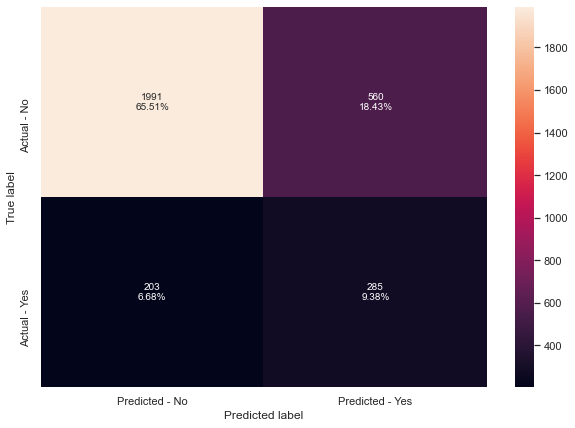

In [167]:
get_metrics_score(lr_estimator_un,X_train_un,X_test,y_train_un,y_test)
make_confusion_matrix(lr_estimator_un,y_test)

#### Downsampling with ClusterCentroids

In [73]:
print("Before DownSampling, counts of label 'Yes': {}".format(sum(y_train==1)))
print("Before DownSampling, counts of label 'No': {} \n".format(sum(y_train==0)))

cc = ClusterCentroids(sampling_strategy = 1,random_state=42)
X_train_under, y_train_under = cc.fit_resample(X_train, y_train)

print("After DownSampling, counts of label 'Yes': {}".format(sum(y_train_under==1)))
print("After DownSampling, counts of label 'No': {} \n".format(sum(y_train_under==0)))

print('After DownSampling, the shape of train_X: {}'.format(X_train_under.shape))
print('After DownSampling, the shape of train_y: {} \n'.format(y_train_under.shape))

Before DownSampling, counts of label 'Yes': 1139
Before DownSampling, counts of label 'No': 5949 

After DownSampling, counts of label 'Yes': 1139
After DownSampling, counts of label 'No': 1139 

After DownSampling, the shape of train_X: (2278, 26)
After DownSampling, the shape of train_y: (2278,) 



In [74]:
log_reg_under = LogisticRegression(random_state = 1)
log_reg_under.fit(X_train_under,y_train_under)

LogisticRegression(random_state=1)

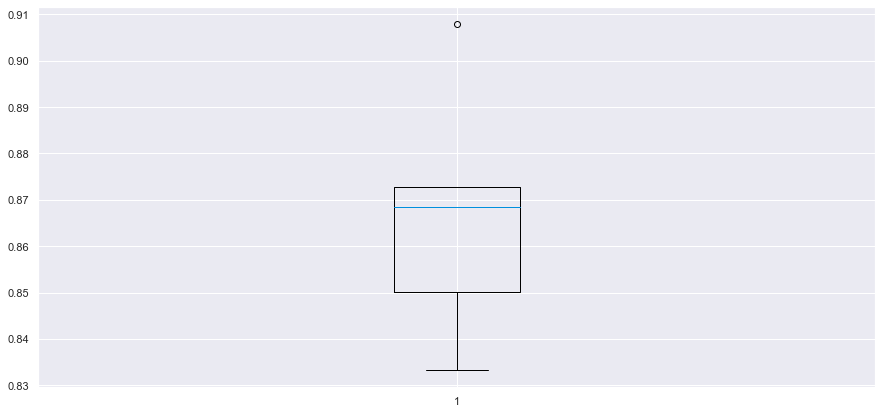

In [75]:
scoring='recall'
kfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=1)    
cv_result_under=cross_val_score(estimator=log_reg_under, X=X_train_under, y=y_train_under, scoring=scoring, cv=kfold)
plt.boxplot(cv_result_under)
plt.show()

Accuracy on training set :  0.8981562774363476
Accuracy on test set :  0.6916748930569266
Recall on training set :  0.8770851624231782
Recall on test set :  0.8647540983606558
Precision on training set :  0.9156736938588451
Precision on test set :  0.32637277648878577


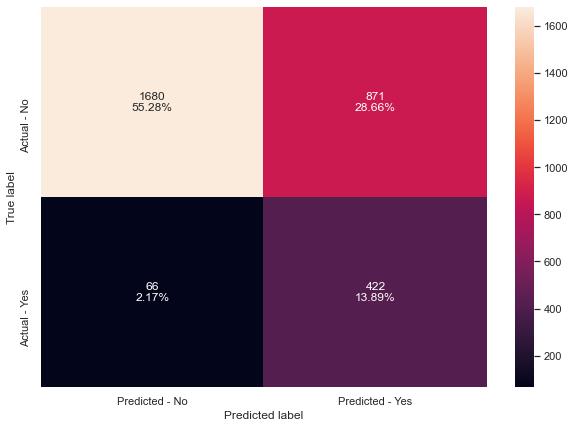

In [76]:
get_metrics_score(log_reg_under,X_train_under,X_test,y_train_under,y_test)
make_confusion_matrix(log_reg_under,y_test)

#### Regularization Undersampling ClusterCentroids

In [213]:
lr_estimator_under = LogisticRegression(random_state=1,solver='saga')
parameters = {'C': np.arange(0.1,1.1,0.1)}
grid_obj = GridSearchCV(lr_estimator_under, parameters, scoring='recall')
grid_obj = grid_obj.fit(X_train_under, y_train_under)
lr_estimator_under = grid_obj.best_estimator_
lr_estimator_under.fit(X_train_under, y_train_under)

LogisticRegression(C=0.1, random_state=1, solver='saga')

Accuracy on training set :  0.7151009657594382
Accuracy on test set :  0.7759131293188549
Recall on training set :  0.5276558384547849
Recall on test set :  0.48565573770491804
Precision on training set :  0.8441011235955056
Precision on test set :  0.3553223388305847


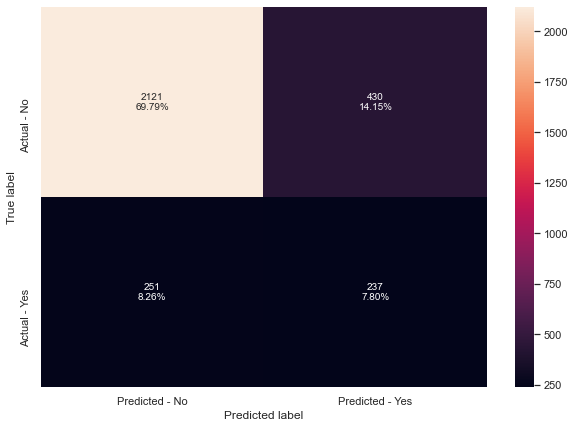

In [214]:
get_metrics_score(lr_estimator_under,X_train_under,X_test,y_train_under,y_test)
make_confusion_matrix(lr_estimator_under,y_test)

## <a id = "link5"></a> Model building - Bagging and Boosting

#### Decision Tree

In [101]:
d_tree = DecisionTreeClassifier(random_state=1)
d_tree.fit(X_train,y_train)

DecisionTreeClassifier(random_state=1)

Accuracy on training set :  1.0
Accuracy on test set :  0.8927278710102007
Recall on training set :  1.0
Recall on test set :  0.7028688524590164
Precision on training set :  1.0
Precision on test set :  0.6545801526717557


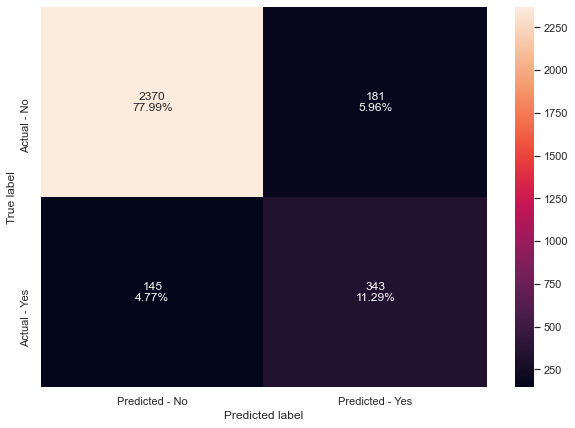

In [103]:
get_metrics_score(d_tree, X_train,X_test,y_train,y_test)
make_confusion_matrix(d_tree,y_test)

#### Random Forest

In [330]:
rf_estimator = RandomForestClassifier(random_state=1)
rf_estimator.fit(X_train,y_train)

RandomForestClassifier(random_state=1)

Accuracy on training set :  1.0
Accuracy on test set :  0.9279368213228035
Recall on training set :  1.0
Recall on test set :  0.6557377049180327
Precision on training set :  1.0
Precision on test set :  0.862533692722372


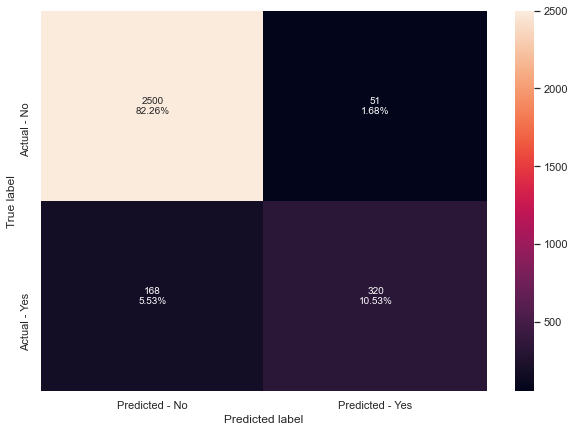

In [331]:
get_metrics_score(rf_estimator, X_train,X_test,y_train,y_test)
make_confusion_matrix(rf_estimator,y_test)

#### Bagging Classifier

Accuracy on training set :  0.9929458239277652
Accuracy on test set :  0.9187232642316552
Recall on training set :  0.9622475856014048
Recall on test set :  0.6557377049180327
Precision on training set :  0.9936536718041704
Precision on test set :  0.8020050125313283


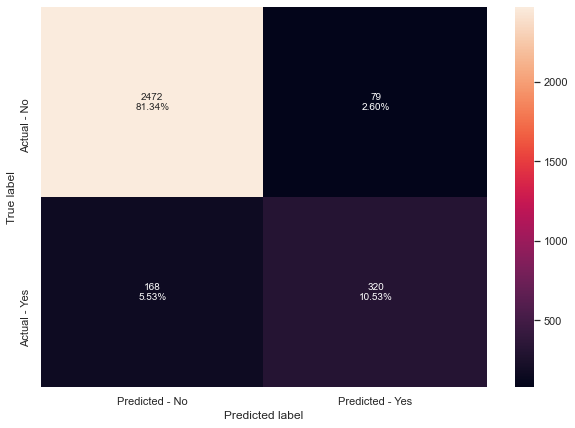

In [109]:
bagging_classifier = BaggingClassifier(random_state=1)
bagging_classifier.fit(X_train,y_train)
get_metrics_score(bagging_classifier, X_train,X_test,y_train,y_test)
make_confusion_matrix(bagging_classifier,y_test)

#### XGBoost Classifier

[09:44:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy on training set :  1.0
Accuracy on test set :  0.9368213228035538
Recall on training set :  1.0
Recall on test set :  0.7540983606557377
Precision on training set :  1.0
Precision on test set :  0.8363636363636363


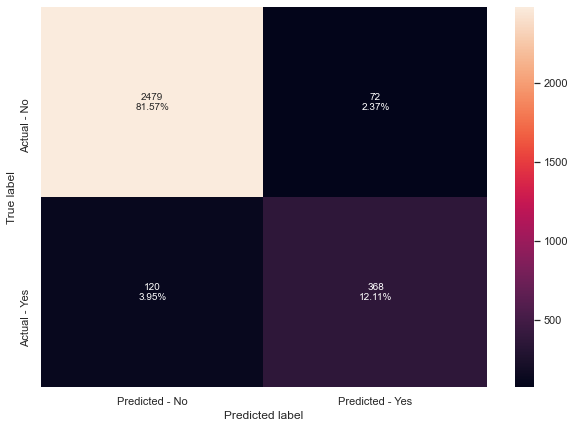

In [110]:
xgb_classifier = XGBClassifier(random_state=1)
xgb_classifier.fit(X_train,y_train)
get_metrics_score(xgb_classifier, X_train,X_test,y_train,y_test)
make_confusion_matrix(xgb_classifier,y_test)

#### AdaBoost Classifier

Accuracy on training set :  0.9308690744920993
Accuracy on test set :  0.9233300427772293
Recall on training set :  0.7251975417032485
Recall on test set :  0.680327868852459
Precision on training set :  0.8235294117647058
Precision on test set :  0.8117359413202934


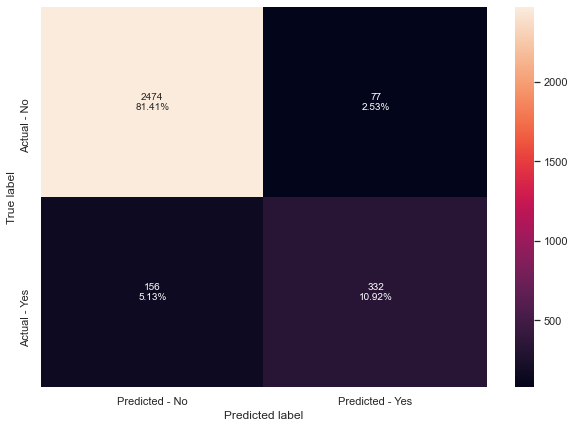

In [111]:
ab_classifier = AdaBoostClassifier(random_state=1)
ab_classifier.fit(X_train,y_train)
get_metrics_score(ab_classifier,X_train,X_test,y_train,y_test)
make_confusion_matrix(ab_classifier,y_test)

#### Gradient Boosting Classifier

In [333]:
gb_classifier = GradientBoostingClassifier(random_state=1)
gb_classifier.fit(X_train,y_train)

GradientBoostingClassifier(random_state=1)

Accuracy on training set :  0.9469525959367946
Accuracy on test set :  0.9318854886475815
Recall on training set :  0.7559262510974539
Recall on test set :  0.6864754098360656
Precision on training set :  0.8978102189781022
Precision on test set :  0.8611825192802056


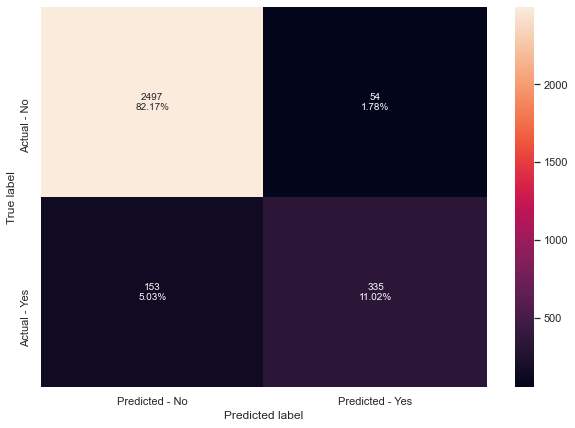

In [334]:
get_metrics_score(gb_classifier,X_train,X_test,y_train,y_test)
make_confusion_matrix(gb_classifier,y_test)

## <a id = "link6"></a> Hyperparameter tuning using grid search

#### Logistic Regression - grid search

In [194]:
%%time 
log_reg_estimator = LogisticRegression(random_state = 1)
pipe = make_pipeline(StandardScaler(), log_reg_estimator)

param_grid = {

    'logisticregression__C': [1.0,2.0],  
    'logisticregression__penalty': ['l2', 'l1'],
    'logisticregression__max_iter': [100, 150]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling GridSearchCV
log_grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5)

# Fitting parameters in GridSeachCV
log_grid_cv.fit(X_train, y_train)

print(
    "Best Parameters:{} \nScore: {}".format(log_grid_cv.best_params_, log_grid_cv.best_score_)
)

Best Parameters:{'logisticregression__C': 2.0, 'logisticregression__max_iter': 100, 'logisticregression__penalty': 'l2'} 
Score: 0.541730427390061
CPU times: user 3.92 s, sys: 547 ms, total: 4.46 s
Wall time: 573 ms


In [239]:
log_reg_tuned = log_grid_cv.best_estimator_
log_reg_tuned1 = make_pipeline(
    StandardScaler(),
    log_reg_tuned
    )
log_reg_tuned1.fit(X_train, y_train) 

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('logisticregression',
                                  LogisticRegression(C=2.0,
                                                     random_state=1))]))])

Accuracy on training set :  0.9020880361173815
Accuracy on test set :  0.8963474827245804
Recall on training set :  0.5513608428446005
Recall on test set :  0.5389344262295082
Precision on training set :  0.7743526510480888
Precision on test set :  0.7450424929178471


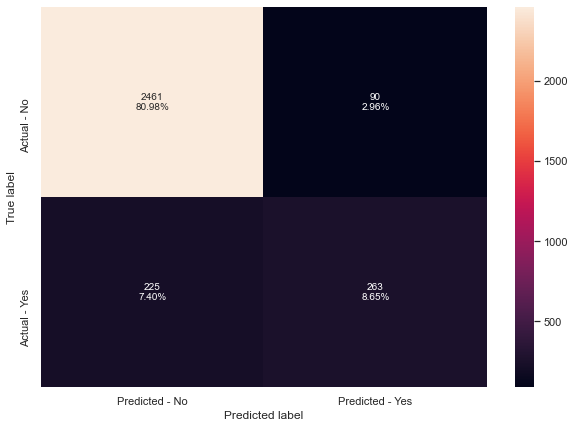

In [240]:
get_metrics_score(log_reg_tuned1,X_train,X_test,y_train,y_test)
make_confusion_matrix(log_reg_tuned1, y_test)

#### Logistic Regression Upsampling - grid search

In [243]:
%%time 
pipe = make_pipeline(StandardScaler(), lr_estimator_over)

param_grid = {

    'logisticregression__C': [1.0,2.0],  
    'logisticregression__penalty': ['l2', 'l1'],
    'logisticregression__max_iter': [100, 150]
}

scorer = metrics.make_scorer(metrics.recall_score)
log_over_grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5)
log_over_grid_cv.fit(X_train_over, y_train_over)

print(
    "Best Parameters:{} \nScore: {}".format(log_over_grid_cv.best_params_, log_over_grid_cv.best_score_)
)

Best Parameters:{'logisticregression__C': 1.0, 'logisticregression__max_iter': 100, 'logisticregression__penalty': 'l2'} 
Score: 0.8534370383982021
CPU times: user 22.6 s, sys: 3.35 s, total: 25.9 s
Wall time: 3.79 s


In [253]:
log_reg_over_tuned = log_over_grid_cv.best_estimator_
log_reg_over_tuned1 = make_pipeline(
    StandardScaler(),
    log_reg_over_tuned
    )
log_reg_over_tuned1.fit(X_train_over, y_train_over)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('logisticregression',
                                  LogisticRegression(random_state=1,
                                                     solver='saga'))]))])

Accuracy on training set :  0.9043536728861994
Accuracy on test set :  0.8650871997367555
Recall on training set :  0.8967893763657757
Recall on test set :  0.6495901639344263
Precision on training set :  0.9105649428230074
Precision on test set :  0.5701438848920863


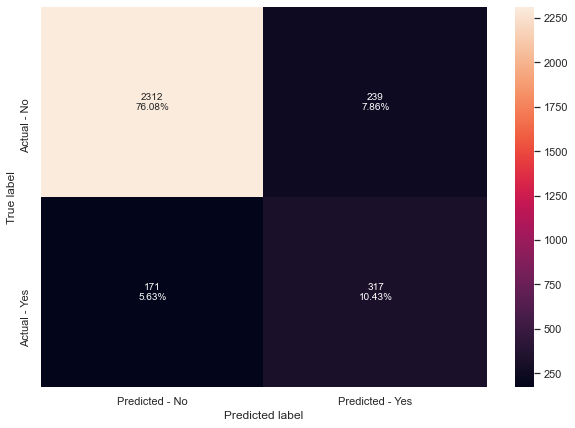

In [254]:
get_metrics_score(log_reg_over_tuned1,X_train_over,X_test,y_train_over,y_test)
make_confusion_matrix(log_reg_over_tuned1, y_test)

#### Logistic Regression Downsampling - grid search

In [204]:
%%time 
pipe = make_pipeline(StandardScaler(), lr_estimator_un)

param_grid = {

    'logisticregression__C': [1.0,2.0],  
    'logisticregression__penalty': ['l2', 'l1'],
    'logisticregression__max_iter': [100, 150]
}

scorer = metrics.make_scorer(metrics.recall_score)

log_under_grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5)
log_under_grid_cv.fit(X_train_under, y_train_under)

print(
    "Best Parameters:{} \nScore: {}".format(log_under_grid_cv.best_params_, log_under_grid_cv.best_score_)
)

Best Parameters:{'logisticregression__C': 1.0, 'logisticregression__max_iter': 100, 'logisticregression__penalty': 'l2'} 
Score: 0.94117397016771
CPU times: user 16 s, sys: 2.31 s, total: 18.3 s
Wall time: 2.36 s


In [257]:
log_reg_under_tuned = log_under_grid_cv.best_estimator_
log_reg_under_tuned1 = make_pipeline(
    StandardScaler(),
    log_reg_under_tuned
    )
log_reg_under_tuned1.fit(X_train_under, y_train_under)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('logisticregression',
                                  LogisticRegression(random_state=1,
                                                     solver='saga'))]))])

Accuracy on training set :  0.9460052677787533
Accuracy on test set :  0.42349457058242845
Recall on training set :  0.9490781387181738
Recall on test set :  0.9487704918032787
Precision on training set :  0.9432809773123909
Precision on test set :  0.21141552511415526


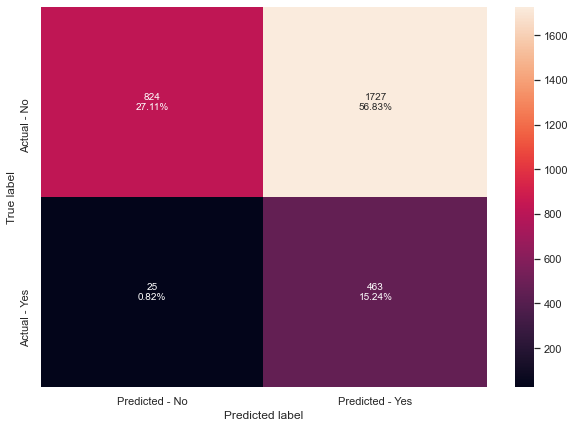

In [259]:
get_metrics_score(log_reg_under_tuned1,X_train_under,X_test,y_train_under,y_test)
make_confusion_matrix(log_reg_under_tuned1, y_test)

#### Decision Tree - grid search

In [308]:
%%time 
dtree_estimator = DecisionTreeClassifier(class_weight={0:0.18,1:0.72},random_state=1)

pipe = make_pipeline(StandardScaler(), dtree_estimator)

param_grid = {

    'decisiontreeclassifier__criterion': ['gini', 'entropy'],
    'decisiontreeclassifier__max_depth': np.arange(2,30), 
    'decisiontreeclassifier__max_leaf_nodes': [2, 3, 5, 10,15],
    'decisiontreeclassifier__min_impurity_decrease': [0.0001,0.001,0.01,0.1],
    'decisiontreeclassifier__min_samples_leaf': [1, 2, 5, 7, 10]
}

scorer = metrics.make_scorer(metrics.recall_score)
dtree_grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5)
dtree_grid_cv.fit(X_train, y_train)

print(
    "Best Parameters:{} \nScore: {}".format(dtree_grid_cv.best_params_, grid_cv.best_score_)
)

Best Parameters:{'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 2, 'decisiontreeclassifier__max_leaf_nodes': 2, 'decisiontreeclassifier__min_impurity_decrease': 0.0001, 'decisiontreeclassifier__min_samples_leaf': 1} 
Score: 0.7463018780431254
CPU times: user 8min 33s, sys: 12.7 s, total: 8min 45s
Wall time: 8min 46s


In [310]:
dtree_tuned = dtree_grid_cv.best_estimator_
dtree_tuned1 = make_pipeline(
    StandardScaler(),
    dtree_tuned
    )
dtree_tuned1.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('decisiontreeclassifier',
                                  DecisionTreeClassifier(class_weight={0: 0.18,
                                                                       1: 0.72},
                                                         criterion='entropy',
                                                         max_depth=2,
                                                         max_leaf_nodes=2,
                                                         min_impurity_decrease=0.0001,
                                                         random_state=1))]))])

Accuracy on training set :  0.7285553047404063
Accuracy on test set :  0.7087857847976308
Recall on training set :  0.8630377524143986
Recall on test set :  0.8073770491803278
Precision on training set :  0.3573246092330062
Precision on test set :  0.33248945147679326


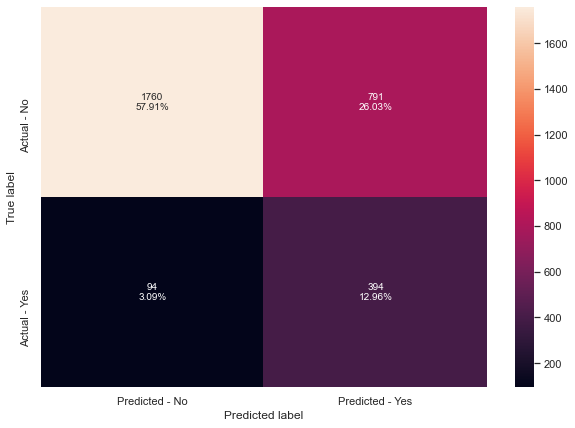

In [311]:
get_metrics_score(dtree_tuned1,X_train,X_test,y_train,y_test)
make_confusion_matrix(dtree_tuned1, y_test)

#### Random Forest - grid search

In [157]:
rf_estimator = RandomForestClassifier(random_state=1)
pipe = make_pipeline(StandardScaler(), rf_estimator)

param_grid = {

    'randomforestclassifier__criterion': ['gini'],
    'randomforestclassifier__max_depth': np.arange(2,3), 
    'randomforestclassifier__max_leaf_nodes': [2, 3,],
    'randomforestclassifier__min_impurity_decrease': [0.0001,0.001],
    'randomforestclassifier__min_samples_leaf': [1, 2]
}

scorer = metrics.make_scorer(metrics.recall_score)
grid_cv_rf = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5)
grid_cv_rf.fit(X_train, y_train)

print(
    "Best Parameters:{} \nScore: {}".format(grid_cv_rf.best_params_, grid_cv_rf.best_score_)
)

Best Parameters:{'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 2, 'randomforestclassifier__max_leaf_nodes': 3, 'randomforestclassifier__min_impurity_decrease': 0.0001, 'randomforestclassifier__min_samples_leaf': 2} 
Score: 0.021075817296545327


In [260]:
rf_tuned = grid_cv_rf.best_estimator_
rf_tuned1 = make_pipeline(
    StandardScaler(),
    rf_tuned
    )
rf_tuned1.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('randomforestclassifier',
                                  RandomForestClassifier(max_depth=2,
                                                         max_leaf_nodes=3,
                                                         min_impurity_decrease=0.0001,
                                                         min_samples_leaf=2,
                                                         random_state=1))]))])

Accuracy on training set :  0.8429740406320542
Accuracy on test set :  0.8417242513984864
Recall on training set :  0.0228270412642669
Recall on test set :  0.014344262295081968
Precision on training set :  1.0
Precision on test set :  1.0


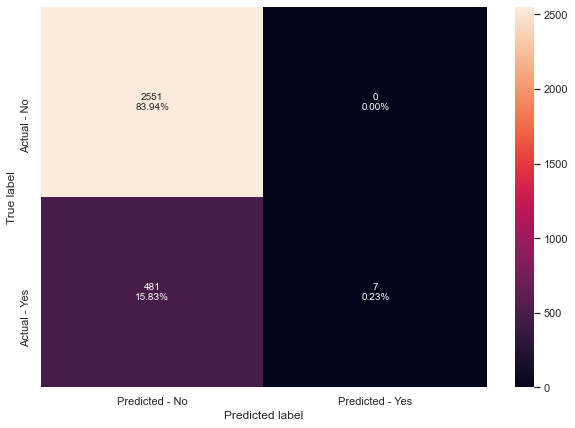

In [261]:
get_metrics_score(rf_tuned1,X_train,X_test,y_train,y_test)
make_confusion_matrix(rf_tuned1, y_test)

#### Bagging Classifier - grid search

In [215]:
bagging_estimator_tuned = BaggingClassifier(random_state=1)
pipe = make_pipeline(StandardScaler(), bagging_estimator_tuned)
parameters = {'max_samples': [0.7,0.8,0.9,1], 
              'max_features': [0.7,0.8,0.9,1],
              'n_estimators' : [10,20,30,40,50],
             }

param_grid = {
    
    
}

scorer = metrics.make_scorer(metrics.recall_score)
grid_cv_bc = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5)
grid_cv_bc.fit(X_train, y_train)

print(
    "Best Parameters:{} \nScore: {}".format(grid_cv_bc.best_params_, grid_cv_bc.best_score_)
)

Best Parameters:{} 
Score: 0.6629028518432645


In [262]:
bagging_tuned = grid_cv_bc.best_estimator_
bagging_tuned1 = make_pipeline(
    StandardScaler(),
    bagging_tuned
    )
bagging_tuned1.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('baggingclassifier',
                                  BaggingClassifier(random_state=1))]))])

Accuracy on training set :  0.9929458239277652
Accuracy on test set :  0.9187232642316552
Recall on training set :  0.9622475856014048
Recall on test set :  0.6536885245901639
Precision on training set :  0.9936536718041704
Precision on test set :  0.8035264483627204


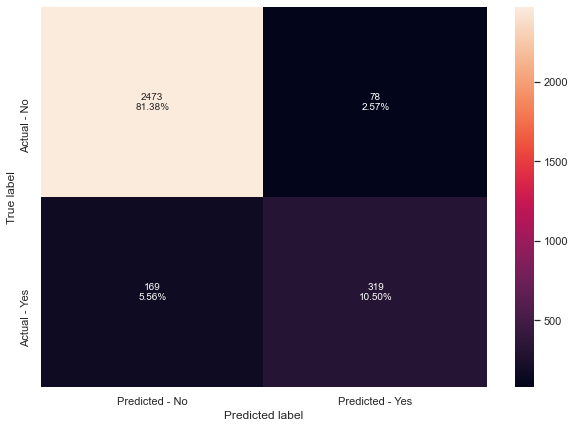

In [263]:
get_metrics_score(bagging_tuned1,X_train,X_test,y_train,y_test)
make_confusion_matrix(bagging_tuned1, y_test)

#### XGBoost - grid search

In [122]:
%%time 
pipe=make_pipeline(StandardScaler(), XGBClassifier(random_state=1,eval_metric='logloss'))
param_grid={'xgbclassifier__n_estimators':np.arange(50,300,50),
            'xgbclassifier__scale_pos_weight':[0,1,2,5,10],
            'xgbclassifier__learning_rate':[0.01,0.1,0.2,0.05], 
            'xgbclassifier__gamma':[0,1,3,5],
            'xgbclassifier__subsample':[0.7,0.8,0.9,1]}

scorer = metrics.make_scorer(metrics.recall_score)
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5)
grid_cv.fit(X_train,y_train)
print("Best parameters are {} with CV score={}:" .format(grid_cv.best_params_,grid_cv.best_score_))

Best parameters are {'xgbclassifier__gamma': 5, 'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__scale_pos_weight': 10, 'xgbclassifier__subsample': 0.9} with CV score=0.9078367725481105:
CPU times: user 14h 49min 40s, sys: 18min 33s, total: 15h 8min 13s
Wall time: 59min 1s


In [123]:
xgb_tuned1 = make_pipeline(
    StandardScaler(),
    XGBClassifier(
        random_state=1,
        n_estimators=100,
        scale_pos_weight=10,
        subsample=0.9,
        learning_rate=0.01,
        gamma=5,
        eval_metric='logloss',
    ),
)
xgb_tuned1.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='logloss',
                               gamma=5, gpu_id=-1, importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=16, num_parallel_tree=1, random_state=1,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=10,
                               subsample=0.9, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

Accuracy on training set :  0.873589164785553
Accuracy on test set :  0.8565317538664035
Recall on training set :  0.9719051799824407
Recall on test set :  0.9016393442622951
Precision on training set :  0.5616438356164384
Precision on test set :  0.5314009661835749


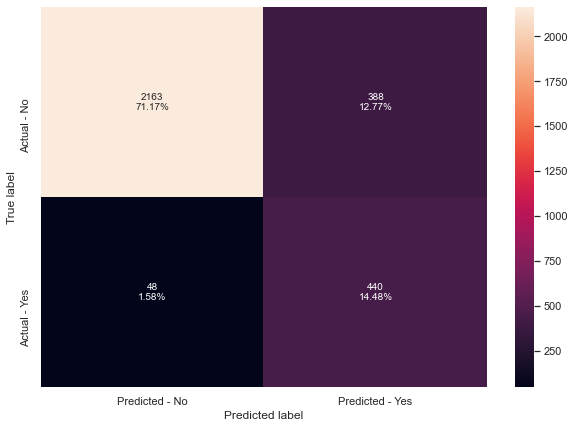

In [124]:
get_metrics_score(xgb_tuned1,X_train,X_test,y_train,y_test)
make_confusion_matrix(xgb_tuned1, y_test)

#### AdaBoost - grid search

In [115]:
%%time 
pipe = make_pipeline(StandardScaler(), AdaBoostClassifier(random_state=1))
param_grid = {
    "adaboostclassifier__n_estimators": np.arange(10, 110, 10),
    "adaboostclassifier__learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "adaboostclassifier__base_estimator": [
        DecisionTreeClassifier(max_depth=1, random_state=1),
        DecisionTreeClassifier(max_depth=2, random_state=1),
        DecisionTreeClassifier(max_depth=3, random_state=1),
    ],
}
scorer = metrics.make_scorer(metrics.recall_score)
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5)
grid_cv.fit(X_train, y_train)

print(
    "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
)

Best Parameters:{'adaboostclassifier__base_estimator': DecisionTreeClassifier(max_depth=2, random_state=1), 'adaboostclassifier__learning_rate': 1, 'adaboostclassifier__n_estimators': 70} 
Score: 0.7515302573614653
CPU times: user 4min 53s, sys: 1.38 s, total: 4min 55s
Wall time: 4min 55s


In [125]:
abc_tuned1 = make_pipeline(
    StandardScaler(),
    AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=2, random_state=1),
        n_estimators=70,
        learning_rate=1,
        random_state=1,
    ),
)

abc_tuned1.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                                          random_state=1),
                                    learning_rate=1, n_estimators=70,
                                    random_state=1))])

Accuracy on training set :  0.9544300225733634
Accuracy on test set :  0.9381375452451465
Recall on training set :  0.8235294117647058
Recall on test set :  0.764344262295082
Precision on training set :  0.8849056603773585
Precision on test set :  0.8363228699551569


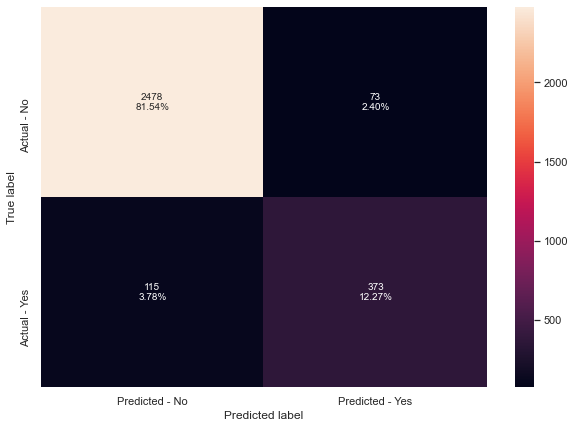

In [126]:
get_metrics_score(abc_tuned1,X_train,X_test,y_train,y_test)
make_confusion_matrix(abc_tuned1, y_test)

#### Gradient Boosting Classifier - grid search

In [234]:
%%time 
gbc_tuned = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),random_state=1)
pipe = make_pipeline(StandardScaler(), gbc_tuned)
param_grid = {
    
    'gradientboostingclassifier__max_features': [0.7,0.8,0.9,1],
    'gradientboostingclassifier__subsample': [0.8,0.9,1],
    'gradientboostingclassifier__n_estimators': [100,150,200,250]
}
scorer = metrics.make_scorer(metrics.recall_score)
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5)
grid_cv.fit(X_train, y_train)

print(
    "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
)


Best Parameters:{'gradientboostingclassifier__max_features': 0.7, 'gradientboostingclassifier__n_estimators': 250, 'gradientboostingclassifier__subsample': 0.9} 
Score: 0.7463018780431254
CPU times: user 4min 28s, sys: 919 ms, total: 4min 29s
Wall time: 4min 29s


In [237]:
gbc_tuned = grid_cv.best_estimator_
gbc_tuned1 = make_pipeline(
    StandardScaler(),
    gbc_tuned
    )
gbc_tuned1.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('gradientboostingclassifier',
                                  GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                                                             max_features=0.7,
                                                             n_estimators=250,
                                                             random_state=1,
                                                             subsample=0.9))]))])

Accuracy on training set :  0.9637415349887133
Accuracy on test set :  0.9397828232971372
Recall on training set :  0.8323090430201932
Recall on test set :  0.7397540983606558
Precision on training set :  0.9349112426035503
Precision on test set :  0.8657074340527577


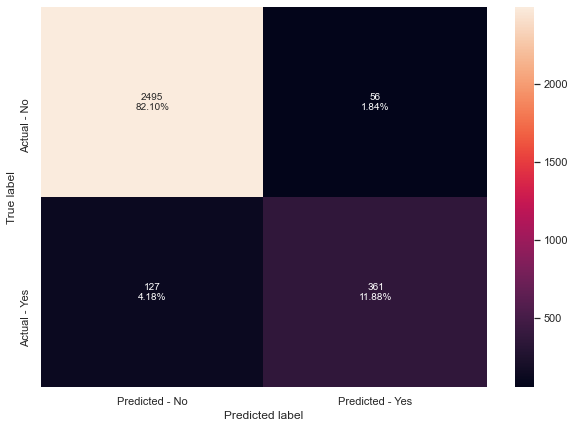

In [238]:
get_metrics_score(gbc_tuned1,X_train,X_test,y_train,y_test)
make_confusion_matrix(gbc_tuned1, y_test)

## <a id = "link7"></a> Hyperparameter Tuning Using Random Search

#### Logistic Regression - random search

In [272]:
%%time 
log_reg_estimator = LogisticRegression(random_state = 1)
pipe = make_pipeline(StandardScaler(), log_reg_estimator)

param_grid = {

    'logisticregression__C': [1.0,2.0],  
    'logisticregression__penalty': ['l2', 'l1'],
    'logisticregression__max_iter': [100, 150]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
random_search_log = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
random_search_log.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(random_search_log.best_params_,random_search_log.best_score_))

Best parameters are {'logisticregression__penalty': 'l2', 'logisticregression__max_iter': 100, 'logisticregression__C': 2.0} with CV score=0.541730427390061:
CPU times: user 3.87 s, sys: 511 ms, total: 4.38 s
Wall time: 562 ms


In [273]:
log_tuned_n = random_search_log.best_estimator_
log_tuned2 = make_pipeline(
    StandardScaler(),
    log_tuned_n
    )
log_tuned2.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('logisticregression',
                                  LogisticRegression(C=2.0,
                                                     random_state=1))]))])

Accuracy on training set :  0.9020880361173815
Accuracy on test set :  0.8963474827245804
Recall on training set :  0.5513608428446005
Recall on test set :  0.5389344262295082
Precision on training set :  0.7743526510480888
Precision on test set :  0.7450424929178471


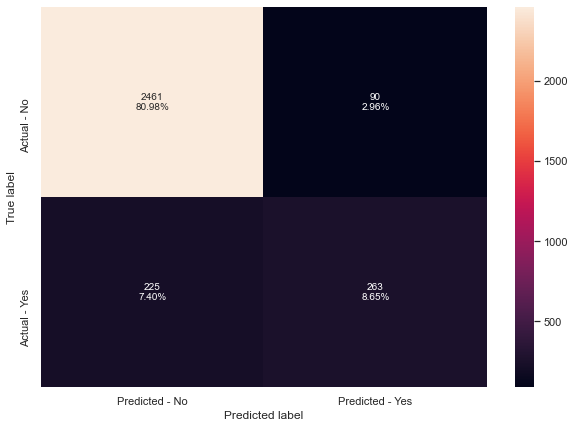

In [274]:
get_metrics_score(log_tuned2,X_train,X_test,y_train,y_test)
make_confusion_matrix(log_tuned2, y_test)

#### Logistic Regression Upsampling - random search

In [277]:
%%time 
pipe = make_pipeline(StandardScaler(), lr_estimator_over)

param_grid = {
    'logisticregression__C': [1.0,2.0],  
    'logisticregression__penalty': ['l2', 'l1'],
    'logisticregression__max_iter': [100, 150]
}

scorer = metrics.make_scorer(metrics.recall_score)
random_search_log_over = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1)
random_search_log_over.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(random_search_log_over.best_params_,random_search_log_over.best_score_))

Best parameters are {'logisticregression__penalty': 'l2', 'logisticregression__max_iter': 100, 'logisticregression__C': 1.0} with CV score=0.8534370383982021:
CPU times: user 22.8 s, sys: 2.71 s, total: 25.5 s
Wall time: 3.68 s


In [278]:
log_over_tuned_n = random_search_log_over.best_estimator_
log_over_tuned2 = make_pipeline(
    StandardScaler(),
    log_over_tuned_n
    )
log_over_tuned2.fit(X_train_over, y_train_over)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('logisticregression',
                                  LogisticRegression(random_state=1,
                                                     solver='saga'))]))])

Accuracy on training set :  0.9043536728861994
Accuracy on test set :  0.8650871997367555
Recall on training set :  0.8967893763657757
Recall on test set :  0.6495901639344263
Precision on training set :  0.9105649428230074
Precision on test set :  0.5701438848920863


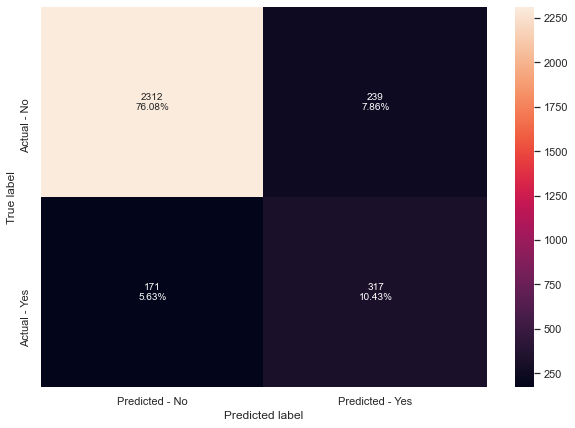

In [279]:
get_metrics_score(log_over_tuned2,X_train_over,X_test,y_train_over,y_test)
make_confusion_matrix(log_over_tuned2, y_test)

#### Logistic Regression Downsampling

In [280]:
%%time 
pipe = make_pipeline(StandardScaler(), lr_estimator_un)

param_grid = {
    'logisticregression__C': [1.0,2.0],  
    'logisticregression__penalty': ['l2', 'l1'],
    'logisticregression__max_iter': [100, 150]
}

scorer = metrics.make_scorer(metrics.recall_score)
random_search_log_un = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1)
random_search_log_un.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(random_search_log_un.best_params_,random_search_log_un.best_score_))

Best parameters are {'logisticregression__penalty': 'l1', 'logisticregression__max_iter': 100, 'logisticregression__C': 1.0} with CV score=0.8209096529870934:
CPU times: user 8.04 s, sys: 1.11 s, total: 9.15 s
Wall time: 1.18 s


In [281]:
log_un_tuned_n = random_search_log_un.best_estimator_
log_un_tuned2 = make_pipeline(
    StandardScaler(),
    log_un_tuned_n
    )
log_un_tuned2.fit(X_train_un, y_train_un)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('logisticregression',
                                  LogisticRegression(penalty='l1',
                                                     random_state=1,
                                                     solver='saga'))]))])

Accuracy on training set :  0.8252853380158033
Accuracy on test set :  0.8203356367226061
Recall on training set :  0.8226514486391572
Recall on test set :  0.8217213114754098
Precision on training set :  0.8270079435127978
Precision on test set :  0.4662790697674419


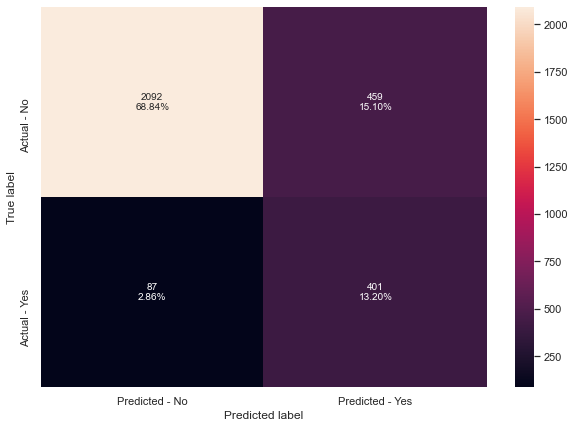

In [282]:
get_metrics_score(log_un_tuned2,X_train_un,X_test,y_train_un,y_test)
make_confusion_matrix(log_un_tuned2, y_test)

#### Decision Tree - random search

In [285]:
%%time

pipe = make_pipeline(StandardScaler(), DecisionTreeClassifier(class_weight={0:0.18,1:0.72},random_state=1))
param_grid = {
    'decisiontreeclassifier__max_depth': np.arange(2,30), 
    'decisiontreeclassifier__min_samples_leaf': [1, 2, 5, 7, 10],    
    'decisiontreeclassifier__max_leaf_nodes': [2, 3, 5, 10,15],
    'decisiontreeclassifier__min_impurity_decrease': [0.0001,0.001,0.01,0.1]
    
}
scorer = metrics.make_scorer(metrics.recall_score)
random_search_dtree = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1)
random_search_dtree.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(random_search_dtree.best_params_,random_search_dtree.best_score_))

Best parameters are {'decisiontreeclassifier__min_samples_leaf': 7, 'decisiontreeclassifier__min_impurity_decrease': 0.0001, 'decisiontreeclassifier__max_leaf_nodes': 2, 'decisiontreeclassifier__max_depth': 25} with CV score=0.8437359919622844:
CPU times: user 4.07 s, sys: 109 ms, total: 4.18 s
Wall time: 4.18 s


In [286]:
dtree_tuned_n = random_search_dtree.best_estimator_
dtree_tuned2 = make_pipeline(
    StandardScaler(),
    dtree_tuned_n
    )
dtree_tuned2.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('decisiontreeclassifier',
                                  DecisionTreeClassifier(class_weight={0: 0.18,
                                                                       1: 0.72},
                                                         max_depth=25,
                                                         max_leaf_nodes=2,
                                                         min_impurity_decrease=0.0001,
                                                         min_samples_leaf=7,
                                                         random_state=1))]))])

Accuracy on training set :  0.7412528216704289
Accuracy on test set :  0.7285291214215203
Recall on training set :  0.8463564530289728
Recall on test set :  0.7950819672131147
Precision on training set :  0.36751810903545556
Precision on test set :  0.34860736747529203


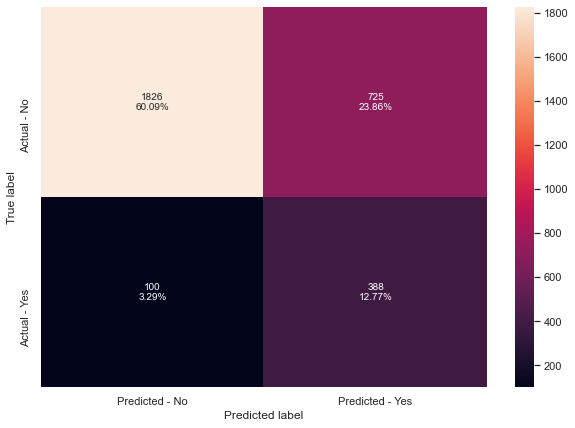

In [287]:
get_metrics_score(dtree_tuned2,X_train,X_test,y_train,y_test)
make_confusion_matrix(dtree_tuned2, y_test)

#### Random Forest - random search

In [288]:
%%time

# Creating pipeline
pipe = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=1))

# Parameter grid to pass in GridSearchCV
param_grid = {
    'randomforestclassifier__max_depth': list(np.arange(5,30,5)) + [None],
    'randomforestclassifier__max_features': ['sqrt','log2',None],
    'randomforestclassifier__min_samples_leaf': np.arange(1,15,5),
    'randomforestclassifier__min_samples_split': np.arange(2,20,5),
    'randomforestclassifier__n_estimators': np.arange(10,110,10)    
}
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
random_search_rf = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
random_search_rf.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(random_search_rf.best_params_,random_search_rf.best_score_))

Best parameters are {'randomforestclassifier__n_estimators': 80, 'randomforestclassifier__min_samples_split': 7, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_features': None, 'randomforestclassifier__max_depth': 15} with CV score=0.6901112914444703:
CPU times: user 1min 48s, sys: 390 ms, total: 1min 48s
Wall time: 1min 48s


In [289]:
rf_tuned_n = random_search_rf.best_estimator_
rf_tuned2 = make_pipeline(
    StandardScaler(),
    rf_tuned_n
    )
rf_tuned2.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('randomforestclassifier',
                                  RandomForestClassifier(max_depth=15,
                                                         max_features=None,
                                                         min_samples_split=7,
                                                         n_estimators=80,
                                                         random_state=1))]))])

Accuracy on training set :  0.9839164785553047
Accuracy on test set :  0.9256334320500165
Recall on training set :  0.9174714661984197
Recall on test set :  0.6967213114754098
Precision on training set :  0.9812206572769953
Precision on test set :  0.8133971291866029


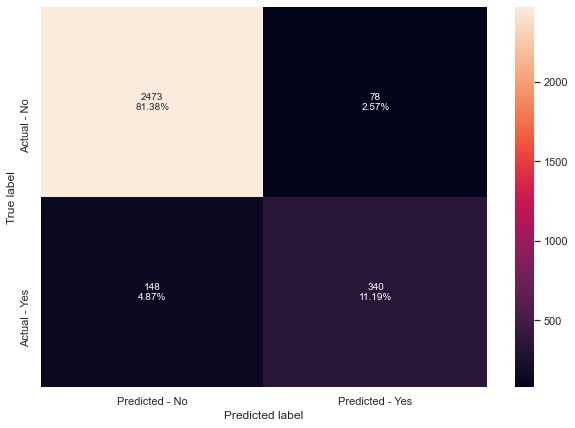

In [290]:
get_metrics_score(rf_tuned2,X_train,X_test,y_train,y_test)
make_confusion_matrix(rf_tuned2, y_test)

#### Bagging Classifier - random search

In [293]:
%%time

# Creating pipeline
pipe = make_pipeline(StandardScaler(), BaggingClassifier(random_state=1))

# Parameter grid to pass in GridSearchCV
param_grid = {
              'baggingclassifier__max_samples': [0.7,0.8,0.9,1], 
              'baggingclassifier__max_features': [0.7,0.8,0.9,1],
              'baggingclassifier__n_estimators' : [10,20,30,40,50],
}
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
random_search_bag  = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
random_search_bag .fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(random_search_bag .best_params_,random_search_bag .best_score_))

Best parameters are {'baggingclassifier__n_estimators': 50, 'baggingclassifier__max_samples': 0.7, 'baggingclassifier__max_features': 0.9} with CV score=0.680477625782518:
CPU times: user 1min 6s, sys: 384 ms, total: 1min 6s
Wall time: 1min 7s


In [294]:
bag_tuned_n = random_search_bag.best_estimator_
bag_tuned2 = make_pipeline(
    StandardScaler(),
    bag_tuned_n
    )
bag_tuned2.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('baggingclassifier',
                                  BaggingClassifier(max_features=0.9,
                                                    max_samples=0.7,
                                                    n_estimators=50,
                                                    random_state=1))]))])

Accuracy on training set :  0.9929458239277652
Accuracy on test set :  0.926620598881211
Recall on training set :  0.9587357330992098
Recall on test set :  0.6680327868852459
Precision on training set :  0.9972602739726028
Precision on test set :  0.8423772609819121


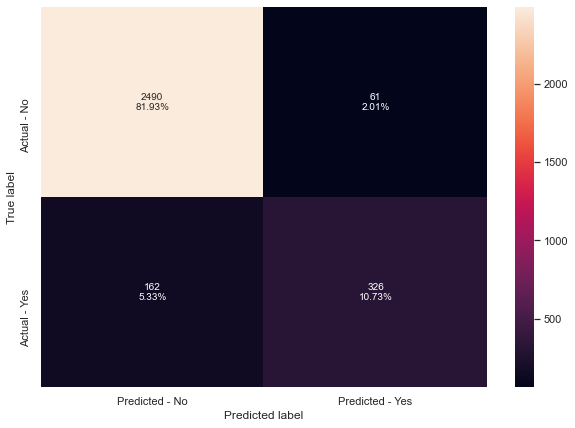

In [295]:
get_metrics_score(bag_tuned2,X_train,X_test,y_train,y_test)
make_confusion_matrix(bag_tuned2, y_test)

#### XGBoost - random search

In [296]:
%%time

# Creating pipeline
pipe = make_pipeline(StandardScaler(), XGBClassifier(random_state=1,eval_metric='logloss'))

# Parameter grid to pass in GridSearchCV
param_grid = {
            'xgbclassifier__n_estimators':np.arange(50,300,50),
            'xgbclassifier__scale_pos_weight':[0,1,2,5,10],
            'xgbclassifier__learning_rate':[0.01,0.1,0.2,0.05], 
            'xgbclassifier__gamma':[0,1,3,5],
            'xgbclassifier__subsample':[0.7,0.8,0.9,1]
}
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
random_search_xgb.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(random_search_xgb.best_params_,random_search_xgb.best_score_))

Best parameters are {'xgbclassifier__subsample': 1, 'xgbclassifier__scale_pos_weight': 10, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__gamma': 5} with CV score=0.8981760568822938:
CPU times: user 24min 40s, sys: 44.2 s, total: 25min 25s
Wall time: 1min 41s


In [297]:
xgb_tuned_n = random_search_xgb.best_estimator_
xgb_tuned2 = make_pipeline(
    StandardScaler(),
    xgb_tuned_n
    )
xgb_tuned2.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('xgbclassifier',
                                  XGBClassifier(base_score=0.5,
                                                booster='gbtree',
                                                colsample_bylevel=1,
                                                colsample_bynode=1,
                                                colsample_bytree=1,
                                                eval_metric='logloss', gamma=5,
                                                gpu_id=-1,
                                                importance_type='gain',
                                                interaction_constraints='',
                                                learning_rate=0.05,
                                                max_delta_step=0, max_depth=6,
                          

Accuracy on training set :  0.899548532731377
Accuracy on test set :  0.8759460348798948
Recall on training set :  0.9841966637401229
Recall on test set :  0.9057377049180327
Precision on training set :  0.6176308539944904
Precision on test set :  0.5717981888745148


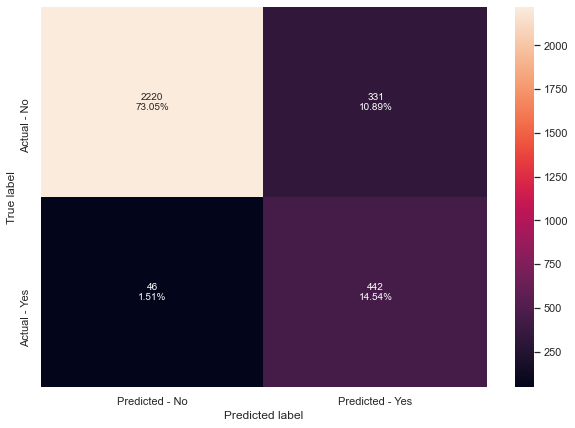

In [298]:
get_metrics_score(xgb_tuned2,X_train,X_test,y_train,y_test)
make_confusion_matrix(xgb_tuned2, y_test)

#### AdaBoost - random search

In [299]:
%%time

# Creating pipeline
pipe = make_pipeline(StandardScaler(), AdaBoostClassifier(random_state=1))

# Parameter grid to pass in GridSearchCV
param_grid = {
    "adaboostclassifier__n_estimators": np.arange(10, 110, 10),
    "adaboostclassifier__learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "adaboostclassifier__base_estimator": [
        DecisionTreeClassifier(max_depth=1, random_state=1),
        DecisionTreeClassifier(max_depth=2, random_state=1),
        DecisionTreeClassifier(max_depth=3, random_state=1),
    ],
}
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
random_search_abc = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
random_search_abc.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(random_search_abc.best_params_,random_search_abc.best_score_))

Best parameters are {'adaboostclassifier__n_estimators': 50, 'adaboostclassifier__learning_rate': 1, 'adaboostclassifier__base_estimator': DecisionTreeClassifier(max_depth=2, random_state=1)} with CV score=0.7488909498415643:
CPU times: user 1min 46s, sys: 521 ms, total: 1min 47s
Wall time: 1min 47s


In [300]:
abc_tuned_n = random_search_abc.best_estimator_
abc_tuned2 = make_pipeline(
    StandardScaler(),
    abc_tuned_n
    )
abc_tuned2.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('adaboostclassifier',
                                  AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                                                           random_state=1),
                                                     learning_rate=1,
                                                     random_state=1))]))])

Accuracy on training set :  0.9492099322799097
Accuracy on test set :  0.9364922671931556
Recall on training set :  0.800702370500439
Recall on test set :  0.7684426229508197
Precision on training set :  0.8727272727272727
Precision on test set :  0.8241758241758241


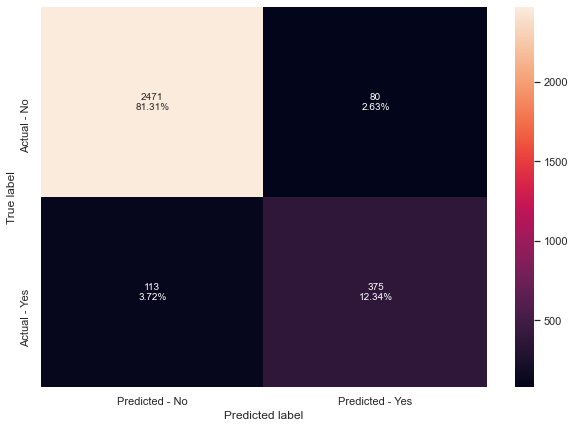

In [301]:
get_metrics_score(abc_tuned2,X_train,X_test,y_train,y_test)
make_confusion_matrix(abc_tuned2, y_test)

#### Gradient Boosting - random search

In [302]:
%%time

# Creating pipeline
pipe = make_pipeline(StandardScaler(), GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),random_state=1))

# Parameter grid to pass in GridSearchCV
param_grid = {
    'gradientboostingclassifier__max_features': [0.7,0.8,0.9,1],
    'gradientboostingclassifier__subsample': [0.8,0.9,1],
    'gradientboostingclassifier__n_estimators': [100,150,200,250]
}
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
random_search_gb = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
random_search_gb.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(random_search_gb.best_params_,random_search_gb.best_score_))

Best parameters are {'gradientboostingclassifier__subsample': 0.9, 'gradientboostingclassifier__n_estimators': 250, 'gradientboostingclassifier__max_features': 0.7} with CV score=0.7463018780431254:
CPU times: user 4min 35s, sys: 1.07 s, total: 4min 36s
Wall time: 4min 37s


In [303]:
gb_tuned_n = random_search_gb.best_estimator_
gb_tuned2 = make_pipeline(
    StandardScaler(),
    gb_tuned_n
    )
gb_tuned2.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('gradientboostingclassifier',
                                  GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                                                             max_features=0.7,
                                                             n_estimators=250,
                                                             random_state=1,
                                                             subsample=0.9))]))])

Accuracy on training set :  0.9637415349887133
Accuracy on test set :  0.9397828232971372
Recall on training set :  0.8323090430201932
Recall on test set :  0.7397540983606558
Precision on training set :  0.9349112426035503
Precision on test set :  0.8657074340527577


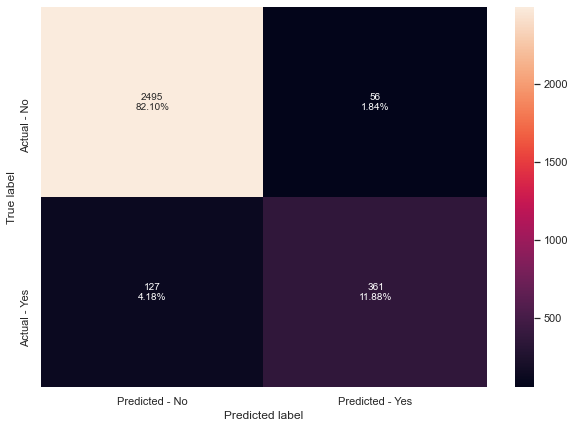

In [304]:
get_metrics_score(gb_tuned2,X_train,X_test,y_train,y_test)
make_confusion_matrix(gb_tuned2, y_test)

## <a id = "link8"></a> Model Performances

### Model evaluation criterion:
The Thera Bank is observing a decline in the number of users of their credit cards. Since loss of credit card customers would lead the bank to financial loss, the bank is interested in identifying those customers who are about to leave.

#### Model can make wrong predictions as:
1. Predicting a customer will leave the bank and the customer does not - Loss of resources
2. Predicting a customer will not leave and the customer leaves - Loss of revenue, potentially financial loss. 

#### Which case is more important? 
Minimizing false negatives or the case when it is predicted that customer will not leave and the customer leaves is more important in this scenario. Therefore, maximizing Recall or minimizing false negatives is the imporant metric when comparing the models.

In [317]:
models = []  

models.append(
    (
        "LR",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("log_reg", log_reg),
            ]
        ),
    )
)

models.append(
    (
        "DTREE",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("decision_tree", d_tree),
            ]
        ),
    )
)

models.append(
    (
        "RF",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("random_forest", rf_estimator),
            ]
        ),
    )
)

models.append(
    (
        "BC",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("bagging_classifier", bagging_classifier),
            ]
        ),
    )
)
models.append(
    (
        "XGB",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("xgboost", xgb_classifier),
            ]
        ),
    )
)

models.append(
    (
        "ADB",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("adaboost", ab_classifier),
            ]
        ),
    )
)
models.append(
    (
        "GBM",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("gradient_boosting", gb_classifier),
            ]
        ),
    )
)


results = []  
names = []  

for name, model in models:
    scoring = "recall"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scoring, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))

LR: 54.43504134786304
DTREE: 68.83259911894274
RF: 66.19870159981451
BC: 66.63575237653605
[14:43:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:43:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:43:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:43:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learne

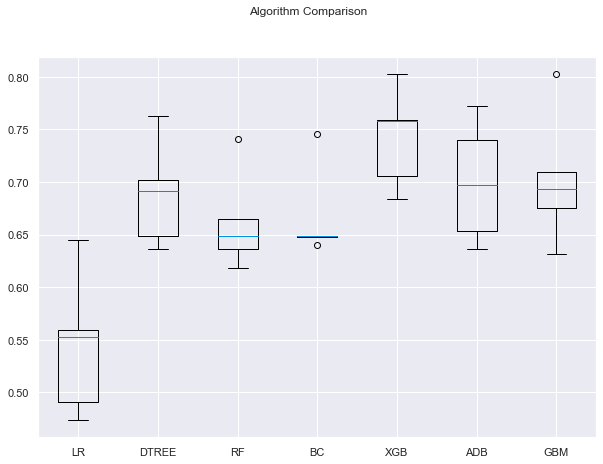

In [318]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

- We can see that XGBoost is giving the highest cross validated recall followed by AdaBoost
- The boxplot shows that the performance of both the models is consistent and a little skewed to the right. There are no outliers for XGBoost or AdaBoost.

#### Grid Search Models Comparison

In [339]:
models2 = []  

models2.append(
    (
        "LR_grid_search",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("log_reg_grid_search", log_reg_tuned1),
            ]
        ),
    )
)
models2.append(
    (
        "Dtree_grid_search",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("decision_tree_grid_search", dtree_tuned1),
            ]
        ),
    )
)

models2.append(
    (
        "RF_grid_search",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("random_forest_grid_search", rf_tuned1),
            ]
        ),
    )
)

models2.append(
    (
        "Bagging_grid_search",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("bagging_grid_search", bagging_tuned1),
            ]
        ),
    )
)

models2.append(
    (
        "XGB_grid_search",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("xgboost_grid_search", xgb_tuned1),
            ]
        ),
    )
)

models2.append(
    (
        "ABC_grid_search",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("adaboost_grid_search", abc_tuned1),
            ]
        ),
    )
)

models2.append(
    (
        "GB_grid_search",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("gradient_boosting_grid_search", gbc_tuned1),
            ]
        ),
    )
)



results = []  
names = []  

for name, model in models2:
    scoring = "recall"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scoring, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))

LR_grid_search: 54.52276064610866
Dtree_grid_search: 85.77865368266482
RF_grid_search: 2.370739624391375
Bagging_grid_search: 66.63575237653605
XGB_grid_search: 90.16577788082542
ABC_grid_search: 73.13432259061751
GB_grid_search: 73.39979905711415


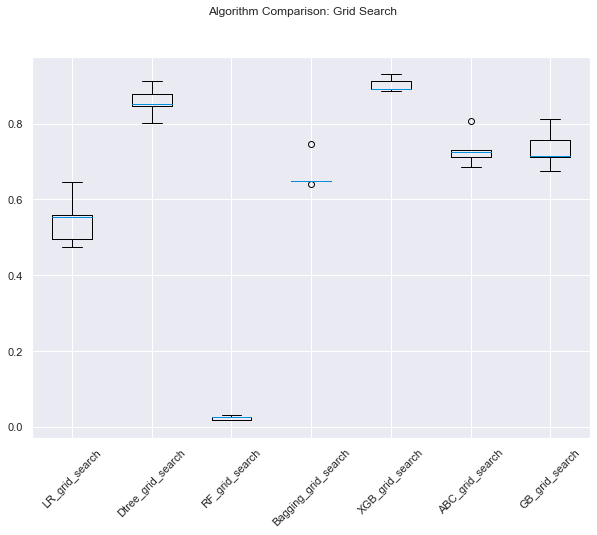

In [340]:
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison: Grid Search")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names, rotation = 45)

plt.show()

- We can see that XGBoost with grid search is giving the highest cross validated recall again. This time however 
followed by Decision Tree with Grid Search

#### Random Search Models Comparison

In [341]:
models3 = []  

models3.append(
    (
        "LR_random_search",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("log_reg_random_search", log_tuned2),
            ]
        ),
    )
)
models3.append(
    (
        "Dtree_random_search",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("decision_tree_random_search", dtree_tuned2),
            ]
        ),
    )
)

models3.append(
    (
        "RF_random_search",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("random_forest_random_search", rf_tuned2),
            ]
        ),
    )
)
models3.append(
    (
        "Bagging_random_search",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("bagging_random_search", bag_tuned2),
            ]
        ),
    )
)
models3.append(
    (
        "XGB_random_search",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("xgboost_random_search", xgb_tuned2),
            ]
        ),
    )
)

models3.append(
    (
        "ABC_random_search",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("adaboost_random_search", abc_tuned2),
            ]
        ),
    )
)

models3.append(
    (
        "GB_random_search",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("gradient_boosting_random_search", gb_tuned2),
            ]
        ),
    )
)



results = []  
names = []  

for name, model in models3:
    scoring = "recall"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scoring, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))

LR_random_search: 54.52276064610866
Dtree_random_search: 84.63482494783212
RF_random_search: 69.53358064765438
Bagging_random_search: 67.1640003091429
XGB_random_search: 90.07767215395315
ABC_random_search: 73.75028982146998
GB_random_search: 73.39979905711415


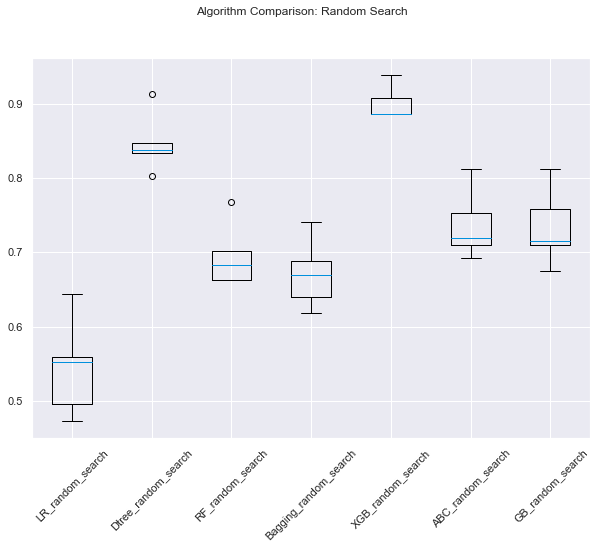

In [342]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison: Random Search")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names, rotation = 45)

plt.show()

- XGBoost is giving the highest cross validated recall followed by Decision Tree when comparing models tuned with random search.

#### Upsampling Models Comparison

In [343]:
models4 = []  

models4.append(
    (
        "LR_upsampling",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("log_upsampling", log_reg_over),
            ]
        ),
    )
)
models4.append(
    (
        "LR_upsampling2",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("log_reg_upsampling", lr_estimator_over),
            ]
        ),
    )
)

models4.append(
    (
        "LR_tuned_grid_search",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("LR_tuned_grid_search", log_reg_over_tuned1),
            ]
        ),
    )
)
models4.append(
    (
        "LR_tuned_random_search",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("LR_tuned_random_search", log_over_tuned2),
            ]
        ),
    )
)




results4 = []  
names = []  

for name, model in models4:
    scoring = "recall"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scoring, cv=kfold
    )
    results4.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))

LR_upsampling: 89.52763073269679
LR_upsampling2: 89.52763073269679
LR_tuned_grid_search: 89.52763073269679
LR_tuned_random_search: 89.52763073269679


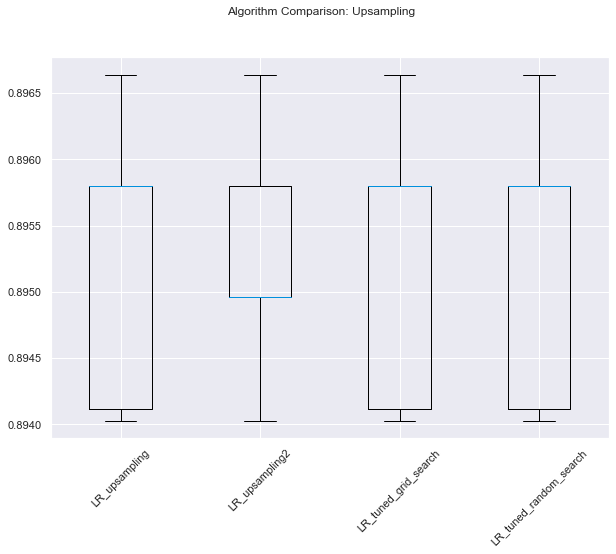

In [344]:
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison: Upsampling")
ax = fig.add_subplot(111)

plt.boxplot(results4)
ax.set_xticklabels(names, rotation = 45)

plt.show()

- Upsampling models give pretty consistent results across the board.

#### Downsampling Model Comparison

In [345]:
models5 = []  

models5.append(
    (
        "LR_downsampling",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("log_downsampling", log_reg_under),
            ]
        ),
    )
)
models5.append(
    (
        "LR_downsampling2",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("log_reg_downsampling", lr_estimator_un),
            ]
        ),
    )
)

models5.append(
    (
        "LR_down_grid_search",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("LR_down_grid_search", log_reg_under_tuned1),
            ]
        ),
    )
)

models5.append(
    (
        "LR_down_random_search",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("LR_down_random_search", log_un_tuned2),
            ]
        ),
    )
)




results5 = []  
names = []  

for name, model in models5:
    scoring = "recall"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  
    cv_result = cross_val_score(
        estimator=model, X=X_train_un, y=y_train_un, scoring=scoring, cv=kfold
    )
    results5.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))

LR_downsampling: 82.26408532344077
LR_downsampling2: 82.08787386969627
LR_down_grid_search: 82.26408532344077
LR_down_random_search: 82.17559316794187


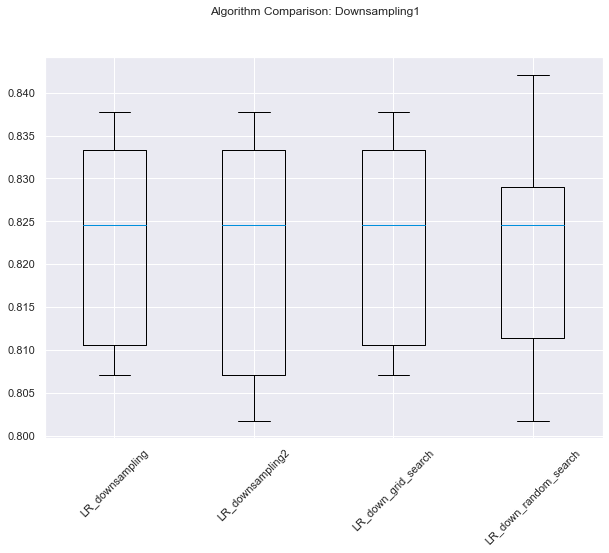

In [346]:
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison: Downsampling1")
ax = fig.add_subplot(111)

plt.boxplot(results5)
ax.set_xticklabels(names, rotation = 45)

plt.show()

- Downsampling models give pretty consistent cross validated recall scores. 

#### Comparing All Models

In [347]:

modells_all = [log_reg, 
               d_tree, 
               rf_estimator, 
               bagging_classifier, 
               xgb_classifier, 
               ab_classifier, 
               gb_classifier, 
               
               #upsampling:
               log_reg_over, 
               lr_estimator_over,
               log_reg_over_tuned1, 
               log_over_tuned2,
               
               #downsampling:
               log_reg_under, 
               lr_estimator_un,        
               log_reg_under_tuned1, 
               log_un_tuned2,
               
               #grid_search:
               log_reg_tuned1, 
               dtree_tuned1, 
               rf_tuned1, 
               bagging_tuned1, 
               xgb_tuned1, 
               abc_tuned1, 
               gbc_tuned1,
               
               #random_search: 
               log_tuned2, 
               dtree_tuned2,
               rf_tuned2,
               bag_tuned2, 
               xgb_tuned2, 
               abc_tuned2, 
               gb_tuned2
    ]

# defining empty lists to add train and test results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []

# looping through all the modells_all to get the metrics score - Accuracy, Recall and Precision
for model in modells_all:
    
    #j = get_metrics_score(model,False)
    j= get_metrics_score(model, X_train,X_test,y_train,y_test)
    acc_train.append(j[0])
    acc_test.append(j[1])
    recall_train.append(j[2])
    recall_test.append(j[3])
    precision_train.append(j[4])
    precision_test.append(j[5])

Accuracy on training set :  0.8882618510158014
Accuracy on test set :  0.8858177031918394
Recall on training set :  0.4618086040386304
Recall on test set :  0.4364754098360656
Precision on training set :  0.7460992907801418
Precision on test set :  0.7473684210526316
Accuracy on training set :  1.0
Accuracy on test set :  0.8927278710102007
Recall on training set :  1.0
Recall on test set :  0.7028688524590164
Precision on training set :  1.0
Precision on test set :  0.6545801526717557
Accuracy on training set :  1.0
Accuracy on test set :  0.9279368213228035
Recall on training set :  1.0
Recall on test set :  0.6557377049180327
Precision on training set :  1.0
Precision on test set :  0.862533692722372
Accuracy on training set :  0.9929458239277652
Accuracy on test set :  0.9187232642316552
Recall on training set :  0.9622475856014048
Recall on test set :  0.6557377049180327
Precision on training set :  0.9936536718041704
Precision on test set :  0.8020050125313283
Accuracy on trainin

In [348]:
comparison_frame = pd.DataFrame({'Model':[
               'Logistic Regression', 
               'Decision Tree', 
               'Random Forest', 
               'Bagging', 
               'Xgb', 
               'AdaBoost', 
               'Gradient Boosting', 
               
               #upsampling:
               'Logistic Regression Upsampling', 
               'Logistic Regression Upsampling (reg)',
               'Logistic Regression Upsampling (reg) GS', 
               'Logistic Regression Upsampling (reg) RS',
               
               #downsampling:
               'Logistic Regression Downsampling', 
               'Logistic Regression Downsampling (reg)',
               'Logistic Regression Downsampling (reg) GS', 
               'Logistic Regression Downsampling (reg) RS',
               
               #grid_search:
               'Logistic Regression GS',
               'Decision Tree GS', 
               'Random Forest GS', 
               'Bagging GS', 
               'Xgb GS', 
               'AdaBoost GS', 
               'Gradient Boosting GS', 
               
               #random_search: 
               'Logistic Regression RS',
               'Decision Tree RS', 
               'Random Forest RS', 
               'Bagging RS', 
               'Xgb RS', 
               'AdaBoost RS', 
               'Gradient Boosting RS', ], 
                                          'Train_Accuracy': acc_train,'Test_Accuracy': acc_test,
                                          'Train_Recall':recall_train,'Test_Recall':recall_test,
                                          'Train_Precision':precision_train,'Test_Precision':precision_test}) 

#Sorting models in decreasing order of test recall
comparison_frame.sort_values(by='Test_Recall',ascending=False)

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision
13,Logistic Regression Downsampling (reg) GS,0.416479,0.423495,0.949078,0.948770,0.209537,0.211416
26,Xgb RS,0.899549,0.875946,0.984197,0.905738,0.617631,0.571798
19,Xgb GS,0.873589,0.856532,0.971905,0.901639,0.561644,0.531401
14,Logistic Regression Downsampling (reg) RS,0.835073,0.820336,0.822651,0.821721,0.492122,0.466279
16,Decision Tree GS,0.728555,0.708786,0.863038,0.807377,0.357325,0.332489
23,Decision Tree RS,0.741253,0.728529,0.846356,0.795082,0.367518,0.348607
11,Logistic Regression Downsampling,0.813770,0.799276,0.803336,0.776639,0.454998,0.430682
27,AdaBoost RS,0.949210,0.936492,0.800702,0.768443,0.872727,0.824176
20,AdaBoost GS,0.954430,0.938138,0.823529,0.764344,0.884906,0.836323
4,Xgb,1.000000,0.936821,1.000000,0.754098,1.000000,0.836364


#### Note:
When looking at highest test recall scores across all models, Logistic Regression with Downsampling and Grid Search stands out. However, it is worth instead taking a look at XGB (random and grid search) since Accuracy and Precision scores are considerably higher than those of Logistic Regression with Downsampling and Grid Search while recall scores are very high as well (90 on test Recall).

In [370]:
xgb_tuned3 = XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='logloss',
                               gamma=5, gpu_id=-1, importance_type='gain',
                               interaction_constraints='', learning_rate=0.05,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, 
                               monotone_constraints='()', n_estimators=50,
                               n_jobs=16, num_parallel_tree=1, random_state=1,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=10,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None)

In [371]:
xgb_tuned3.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=16,
              num_parallel_tree=1, random_state=1, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=10, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

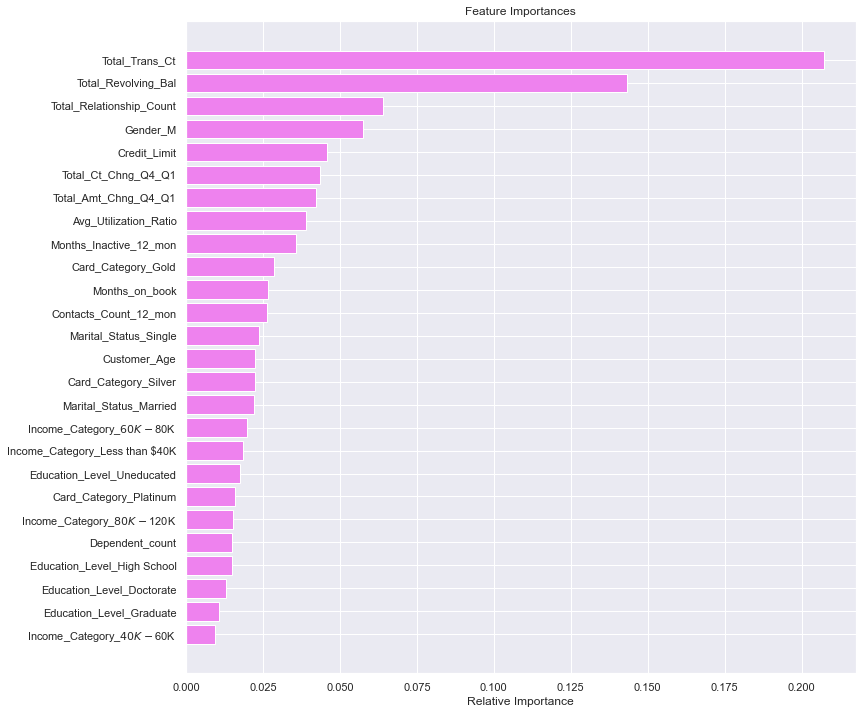

In [372]:
feature_names = X_train.columns
importances = xgb_tuned3.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### CPU and Wall Time Taken by the Grid and Randomized Search in Optimization

Generally, models tuned with Randomized Search were more efficient than models tuned with Grid Searcg in Optimization resulting Randomized Search models taking less CPU and Wall Time. For instance, XGB RS and GS show similar results in terms of Accuracy, Recall and Precision scores, however XGB RS required 1min 41s of Wall time and 25min 25s of total CPU time as compared to XGB GS that took 59min 1s of Wall time and 15h 8min 13s of total CPU time. 

## <a id = "link9"></a> Insights and Recommendations

Analysis shows that customer spending behavior is a strong indicator of whether a customer is going to churn or not. Customers who have lower on average total transactions count, total revolving balance and have fewer relationships with the bank are more likely to churn. 
This suggests that Thera Bank should employ the following strategies:
1. Encourage more credit card spending by providing a rewards system
2. Promote having more relationships with the bank by adding discounts and incentives for opening and maintaining additional accounts with Thera Bank (i.e. mortgage, car loans, checking, savings, etc.)

Additionally, it is advisable to review customer service and problem resolution since the proportion of customers who left the bank rises with the number of contacts in the past 12 months.